# TrenchRipper Master Notebook

## Introduction

This notebook contains the entire `TrenchRipper` pipline, divided into simple steps. This pipline is ideal for Mother <br>Machine image data where cells possess fluorescent segmentation markers. Segmentation on phase or brightfield data <br>is being developed, but is still an experimental feature.

The steps in this pipeline are as follows:
1. Extracting your Mother Machine data (.nd2) into hdf5 format
2. Identifying and cropping individual trenches into kymographs
3. Segmenting cells with a fluorescent marker
4. Determining lineages and object properties

In each step, the user will dynamically specify parameters using a series of interactive diagnostics on their dataset. <br>Following this, a parameter file will be written to disk and then used to deploy a parallel computation on the <br>dataset, either locally or on a SLURM cluster.


This is intended as an end-to-end solution to analyzing Mother Machine data. As such, **it is not trivial to plug data <br>directly into intermediate steps**, as it will lack the correct formatting and associated metadata. A notable <br>exception to this is using another program to segment data. The library references binary segmentation masks using <br>only metadata derived from their associated kymographs. As such, it is possible to generate segmentations on these <br>kymographs elsewhere and place them into the segmentation data path to have `TrenchRipper` act on those <br>segmentations instead. More on this in the segmentation section...

#### Imports

Run this section to import all relavent packages and libraries used in this notebook. You must run this everytime you open a new python kernel.

In [1]:
import paulssonlab.deaton.trenchripper.trenchripper as tr

import warnings

warnings.filterwarnings(action="once")

import matplotlib

matplotlib.rcParams["figure.figsize"] = [20, 10]

#### Specify Paths

Begin by defining the directory in which all processing will be done, as well as the initial nd2 file we will be <br>processing. This line should be run everytime you open a new python kernel.

The format should be: `headpath = "/path/to/folder"` and `nd2file = "/path/to/file.nd2"`

For example:
```
headpath = "/n/scratch2/de64/2019-05-31_validation_data"
nd2file = "/n/scratch2/de64/2019-05-31_validation_data/Main_Experiment.nd2"
```

Ideally, these files should be placed in a storage location with relatively fast I/O

In [2]:
headpath = "/n/scratch2/de64/2020-03-02_plasmid_loss/"
nd2file = "/n/scratch2/de64/2020-03-02_plasmid_loss/Basilisk_SJC25x2_SJC28_Losses.nd2"

## Extract to hdf5 files

In this section, we will be extracting our image data. Currently this notebook only supports `.nd2` format; however <br>there are `.tiff` extractors in the TrenchRipper source files that are being added to `Master.ipynb` soon.

In the abstract, this step will take a single `.nd2` file and split it into a set of `.hdf5` files stored in <br>`headpath/hdf5`. Splitting the file up in this way will facilitate quick procesing in later steps. Each field of <br>view will be split into one or more `.hdf5` files, depending on the number of images per file requested (more on <br>this later). 

To keep track of which output files correspond to which FOVs, as well as to keep track of experiment metadata, the <br>extractor also outputs a `metadata.hdf5` file in the `headpath` folder. The data from this step is accessible in <br>that `metadata.hdf5` file under the `global` key. If you would like to look at this metadata, you may use the <br>`tr.utils.pandas_hdf5_handler` to read from this file. Later steps will add additional metadata under different <br>keys into the `metadata.hdf5` file.

#### Start Dask Workers

First, we start a `dask_controller` instance which will handle all of our parallel processing. The default parameters <br>here work well on O2. The critical arguments here are:

**walltime** : For a cluster, the length of time you will request each node for.

**local** : `True` if you want to perform computation locally. `False` if you want to perform it on a SLURM cluster.

**n_workers** : Number of nodes to request if on the cluster, or number of processes if computing locally.

**memory** : For a cluster, the amount of memory you will request each node for.

**working_directory** : For a cluster, the directory in which data will be spilled to disk. Usually set as a folder in <br>the `headpath`.

In [3]:
dask_controller = tr.trcluster.dask_controller(
    walltime="04:00:00",
    local=False,
    n_workers=40,
    memory="2GB",
    working_directory=headpath + "/dask",
)
dask_controller.startdask()

KeyboardInterrupt: 

After running the above line, you will have a running Dask client. Run the line below and click the link to supervise <br>the computation being administered by the scheduler. 

Don't be alarmed if the screen starts mostly blank, it may take time for your workers to spin up. If you get a 404 <br>error on a cluster, it is likely that your ports are not being forwarded properly. If this occurs, please register <br>the issue on github.

In [ ]:
dask_controller.daskclient

##### Perform Extraction

Now that we have our cluster scheduler spun up, it is time to convert files. This will be handled by the <br>`hdf5_extractor` object. This extractor will pull up each FOV and split it such that each derived `.hdf5` file <br>contains, at maximum, N timepoints of that FOV per file. The image data stored in these files takes the <br>form of `(N,Y,X)` arrays that are accessible using the desired channel name as a key. 

The arguments for this extractor are:

 - **nd2file** : The filepath to the `.nd2` file you intend to extract.
 
 - **headpath** : The folder in which processing is occuring. Should be the same for each step in the pipeline.

 - **tpts_per_file** : The maximum number of timepoints stored in each output `.hdf5` file. Typical values are between 25 <br>and 100.

 - **ignore_fovmetadata** : Used when `.nd2` data is corrupted and does not possess records for stage positions or <br>timepoints. Only set `False` if the extractor throws errors on metadata handling.

 - **nd2reader_override** : Overrides values in metadata recovered using the `nd2reader`. Currently set to <br>`{"z_levels":[],"z_coordinates":[]}` by default to correct a known issue where z coordinates are mistakenly <br>interpreted as a z stack. See the [nd2reader](https://rbnvrw.github.io/nd2reader/) documentation for more info.

In [ ]:
hdf5_extractor = tr.ndextract.hdf5_fov_extractor(
    nd2file,
    headpath,
    tpts_per_file=50,
    ignore_fovmetadata=False,
    nd2reader_override={
        "z_levels": [],
        "z_coordinates": [],
        "fields_of_view": list(range(71)),
        "num_frames": 275,
    },
)

##### Extraction Parameters

Here, you may set the time interval you want to extract. Useful for cropping data to the period exhibiting the dynamics of interest.

Optionally take notes to add to the `metadata.hdf5` file. Notes may also be taken directly in this notebook.

In [ ]:
hdf5_extractor.inter_set_params()

##### Begin Extraction 

Running the following line will start the extraction process. This may be monitored by examining the `Dask Dashboard` <br> under the link displayed earlier. Once the computation is complete, move to the next line.

This step may take a long time, though it is possible to speed it up using additional workers.

In [ ]:
hdf5_extractor.extract(dask_controller)

##### Shutdown Dask

Once extraction is complete, it is likely that you will want to shutdown your `dask_controller` if you are on a <br>
cluster. This is because the specifications of the current `dask_controller` will not be optimal for later steps. <br>
To do this, run the following line and wait for it to complete. If it hangs, interrupt your kernel and re-run it. <br>
If this also fails to shutdown your workers, you will have to manually shut them down using `scancel` in a terminal.

In [ ]:
dask_controller.shutdown()

## Kymographs

Now that you have extracted your data into a series of `.hdf5` files, we will now perform identification and cropping <br>of the individual trenches/growth channels present in the images. This algorithm assumes that your growth trenches <br>are vertically aligned and that they alternate in their orientation from top to bottom. See the example image for the <br>correct geometry:

![example_image](./resources/example_image.jpg)

The output of this step will be a set of `.hdf5` files stored in `headpath/kymograph`. The image data stored in these <br>files takes the form of `(K,T,Y,X)` arrays where K is the trench index, T is time, and Y,X are the crop dimensions. <br>These arrays are accessible using keys of the form `"[Trench Row Number]/[Image Channel]"`. For example, <br>looking up phase channel data of trenches in the topmost row of an image will require the key `"0/Phase"`

### Test Parameters



##### Initialize the interactive kymograph class

As a first step, initialize the `tr.interactive.kymograph_interactive` class that will be help us choose the <br>parameters we will use to generate kymographs. 

In [ ]:
interactive_kymograph = tr.kymograph_interactive(headpath)

##### Examine Images

Here you can manually inspect images before beginning parameter tuning.

In [5]:
interactive_kymograph.view_image_interactive()

interactive(children=(Select(description='FOV number:', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,…

You will now want to select a few test FOVs to try out parameters on, the channel you want to detect trenches on, and <br>the time interval on which you will perform your processing.

The arguments for this step are:

- **seg_channel (string)** : The channel name that you would like to segment on.

- **invert (list)** : Whether or not you want to invert the image before detecting trenches. By default, it is assumed that <br>the trenches have a high pixel intensity relative to the background. This should be the case for Phase Contrast and <br>Fluorescence Imageing, but may not be the case for Brightfield Imaging, in which case you will want to invert the image.

- **fov_list (list)** : List of integers corresponding to the FOVs that you wish to make test kymographs of.

- **t_subsample_step (int)** : Step size to be used for subsampling input files in time, recommend that subsampling results in <br>between 5 and 10 timepoints for quick processing.

Hit the "Run Interact" button to lock in your parameters. The button will become transparent briefly and become solid again <br>when processing is complete. After that has occured, move on to the next step. 

In [5]:
interactive_kymograph.import_hdf5_interactive()

interactive(children=(Dropdown(description='seg_channel', options=('mCherry', 'YFP'), value='mCherry'), Dropdo…

##### Tune "trench-row" detection hyperparameters

The kymograph code begins by detecting the positions of trench rows in the image as follows:

1. Reducing each 2D image to a 1D signal along the y-axis by computing the qth percentile of the data along the x-axis
2. Smooth this signal using a median kernel
3. Normalize the signal by linearly scaling 0. and 1. to the minimum and maximum, respectively
4. Use a set threshold to determine the trench row poisitons

The arguments for this step are:

 - **y_percentile (int)** : Percentile to use for step 1.

 - **smoothing_kernel_y_dim_0 (int)** : Median kernel size to use for step 2.

 - **y_percentile_threshold (float)** : Threshold to use in step 4.

Running the following widget will display the smoothed 1-D signal for each of your timepoints. In addition, the threshold <br>value for each fov will be displayed as a red line.

In [6]:
interactive_kymograph.preview_y_precentiles_interactive()

interactive(children=(IntSlider(value=99, description='y_percentile'), IntSlider(value=29, description='smooth…

##### Tune "trench-row" cropping hyperparameters

Next, we will use the detected rows to perform cropping of the input image in the y-dimension:

1. Determine edges of trench rows based on threshold mask.
2. Filter out rows that are too small.
3. Perform cropping using the "end" of the row as reference (the end referring to the part of the trench farthest from <br>the feeding channel).

Step 3 performs a simple algorithm to determine the orientation of each trench:

```
row_orientations = [] # A list of row orientations, starting from the topmost row
if the number of detected rows == 'Number of Rows': 
    row_orientations.append('Orientation')
elif the number of detected rows < 'Number of Rows':
    row_orientations.append('Orientation when < expected rows')
for row in rows:
    if row_orientations[-1] == downward:
        row_orientations.append(upward)
    elif row_orientations[-1] == upward:
        row_orientations.append(downward)
```

The arguments for this step are:

 - **y_min_edge_dist (int)** : Minimum row length necessary for detection (filters out small detected objects).

 - **padding_y (int)** : Padding to add to the end of trench row when cropping in the y-dimension.

 - **trench_len_y (int)** : Length from the end of each trench row to the feeding channel side of the crop.

 - **Number of Rows (int)** : The number of rows to expect in your image. For instance, two in the example image.

 - **Orientation (int)** : The orientation of the top-most row where 0 corresponds to a trench with a downward-oriented trench <br>opening and 1 corresponds to a trench with an upward-oriented trench opening.

 - **Orientation when < expected rows(int)** : The orientation of the top-most row when the number of detected rows is less than <br>expected. Useful if your trenches drift out of your image in some FOVs.

 - **images_per_row(int)** : How many images to output per row for this widget.

Running the following widget will display y-cropped images for each fov and timepoint.

In [7]:
interactive_kymograph.preview_y_crop_interactive()

interactive(children=(IntSlider(value=50, description='y_min_edge_dist', max=1000, min=5, step=5), IntSlider(v…

##### Tune trench detection hyperparameters

Next, we will detect the positions of trenchs in the y-cropped images as follows:

1. Reducing each 2D image to a 1D signal along the x-axis by computing the qth percentile of the data along the y-axis.
2. Determine the signal background by smoothing this signal using a large median kernel.
3. Subtract the background signal.
4. Smooth the resultant signal using a median kernel.
5. Use an [otsu threhsold](https://imagej.net/Auto_Threshold#Otsu) to determine the trench midpoint poisitons.

After this, x-dimension drift correction of our detected midpoints will be performed as follows:

6. Begin at t=1
7. For $m \in \{midpoints(t)\}$ assign $n \in \{midpoints(t-1)\}$ to m if n is the closest midpoint to m at time $t-1$,<br>
points that are not the closest midpoint to any midpoints in m will not be mapped.
8. Compute the translation of each midpoint at time.
9. Take the average of this value as the x-dimension drift from time t-1 to t.

The arguments for this step are:

**t (int)** : Timepoint to examine the percentiles and threshold in.

**x_percentile (int)** : Percentile to use for step 1.

**background_kernel_x (int)** : Median kernel size to use for step 2.

**smoothing_kernel_x (int)** : Median kernel size to use for step 4.

**otsu_scaling (float)** : Scaling factor to apply to the threshold determined by Otsu's method.

Running the following widget will display the smoothed 1-D signal for each of your timepoints. In addition, the threshold <br>value for each fov will be displayed as a red line. In addition, it will display the detected midpoints for each of your timepoints. <br>If there is too much sparsity, or discontinuity, your drift correction will not be accurate.

In [8]:
interactive_kymograph.preview_x_percentiles_interactive()

interactive(children=(IntSlider(value=0, description='t', max=6), IntSlider(value=85, description='x_percentil…

##### Tune trench cropping hyperparameters

Trench cropping simply uses the drift-corrected midpoints as a reference and crops out some fixed length around them <br>
to produce an output kymograph. **Note that the current implementation does not allow trench crops to overlap**. If your<br>
trench crops do overlap, the error will not be caught here, but will cause issues later in the pipeline. As such, try <br>
to crop your trenches as closely as possible. This issue will be fixed in a later update.

The arguments for this step are:

**trench_width_x (int)** : Trench width to use for cropping.

**trench_present_thr (float)** : Trenches that appear in less than this percent of FOVs will be eliminated from the dataset.<br>
If not removed, missing positions will be inferred from the image drift.

Running the following widget will display a random kymograph for each row in each fov and will also produce midpoint plots <br>showing retained midpoints

In [9]:
interactive_kymograph.preview_kymographs_interactive()

interactive(children=(IntSlider(value=30, description='trench_width_x', max=1000, min=2, step=2), FloatSlider(…

##### Export and save hyperparameters

Run the following line to register and display the parameters you have selected for kymograph creation.

In [10]:
interactive_kymograph.process_results()

Y Percentile 98
Y Smoothing Kernel 41
Y Percentile Threshold 0.2
Minimum Trench Length 80
Y Padding 40
Trench Length 170
Orientation Detection Method 0
Expected Number of Rows (Manual Orientation Detection) 4
Alternate Orientation False
Top Orientation when Row Drifts Out (Manual Orientation Detection) 0
Use Median Drift? True
X Percentile 95
X Background Kernel 41
X Smoothing Kernel 3
Otsu Threshold Scaling 0.0
Minimum X Threshold 211
Trench Width 10
Trench Presence Threshold 0.0
All Channels ['mCherry', 'YFP']
Invert False


If you are satisfied with the above parameters, run the following line to write these parameters to disk at `headpath/kymograph.par`<br>
This file will be used to perform kymograph creation in the next section.

In [11]:
interactive_kymograph.write_param_file()

### Generate Kymograph

##### Start Dask Workers

Again, we start a `dask_controller` instance which will handle all of our parallel processing. The default parameters <br>here work well on O2 for kymograph creation. The critical arguments here are:

**walltime** : For a cluster, the length of time you will request each node for.

**local** : `True` if you want to perform computation locally. `False` if you want to perform it on a SLURM cluster.

**n_workers** : Number of nodes to request if on the cluster, or number of processes if computing locally.

**memory** : For a cluster, the amount of memory you will request each node for.

**working_directory** : For a cluster, the directory in which data will be spilled to disk. Usually set as a folder in <br>the `headpath`.

In [4]:
dask_controller = tr.trcluster.dask_controller(
    walltime="04:00:00",
    death_timeout=30.0,
    local=False,
    n_workers=100,
    memory="8GB",
    working_directory=headpath + "/dask",
)
dask_controller.startdask()

After running the above line, you will have a running Dask client. Run the line below and click the link to supervise <br>the computation being administered by the scheduler. 

Don't be alarmed if the screen starts mostly blank, it may take time for your workers to spin up. If you get a 404 <br>error on a cluster, it is likely that your ports are not being forwarded properly. If this occurs, please register <br>the issue on github.

In [5]:
dask_controller.daskclient

Client Scheduler: tcp://10.120.16.243:54067 Dashboard: http://10.120.16.243:8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


##### Perform Kymograph Cropping

Now that we have our cluster scheduler spun up, we will extract kymographs using the parameters stored in `headpath/kymograph.par`. <br>
This will be handled by the `kymograph_cluster` object. This will detect trenches in all of the files present in `headpath/hdf5` that <br>
you created in the first step. It will then crop these trenches and place the crops in a series of `.hdf5` files in `headpath/kymograph`. <br>
These files will store image data in the form of `(K,T,Y,X)` arrays where K is the trench index, T is time and Y,X are the image dimensions <br>
of the crop.

The arguments for this step are:

 - **headpath** : The folder in which processing is occuring. Should be the same for each step in the pipeline.

 - **trenches_per_file** : The maximum number of trenches stored in each output `.hdf5` file. Typical values are between 25 <br>and 100.

 - **paramfile** : Set to true if you want to use parameters from `headpath/kymograph.par` Otherwise, you will have to specify <br>
 parameters as direct arguments to `kymograph_cluster`.

In [6]:
kymoclust = tr.kymograph.kymograph_cluster(
    headpath=headpath, trenches_per_file=25, paramfile=True
)

##### Begin Kymograph Cropping 

Running the following line will start the cropping process. This may be monitored by examining the `Dask Dashboard` <br>
under the link displayed earlier. Once the computation is complete, move to the next line.

**Do not move on until all tasks are displayed as 'in memory' in Dask.**

In [7]:
kymoclust.generate_kymographs(dask_controller)

/home/de64/miniconda3/envs/trenchripper/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/home/de64/paulssonlab/paulssonlab/src/paulssonlab/deaton/trenchripper/trenchripper/utils.py:92: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df.metadata = store.get_storer(key).attrs.metadata


In [ ]:
kymoclust.cleanup_kymographs()

##### Post-process Images

After the above step, kymographs will have been created for each `.hdf5` input file. They will now need to be reorganized <br>
into a new set of files such that each file has, at most, `trenches_per_file` trenches in each file.

**Do not move on until all tasks are displayed as 'in memory' in Dask.**

In [8]:
kymoclust.post_process(dask_controller)

/home/de64/paulssonlab/paulssonlab/src/paulssonlab/deaton/trenchripper/trenchripper/utils.py:92: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df.metadata = store.get_storer(key).attrs.metadata


##### Check kymograph statistics

Run the next line to display some statistics from kymograph creation. The outputs are:

 - **fovs processed** : The number of FOVs successfully processed out of the total number of FOVs
 - **rows processed** : The number of rows of trenches processed out of the total number of rows
 - **trenches processed** : The number of trenches successfully processed
 - **row/fov** : The average number of rows successfully processed per FOV
 - **trenches/fov** : The average number of trenches successfully processed per FOV
 - **failed fovs** : A list of failed FOVs. Spot check these FOVs in the viewer to determine potential problems

In [9]:
kymoclust.kymo_report()

/home/de64/paulssonlab/paulssonlab/src/paulssonlab/deaton/trenchripper/trenchripper/utils.py:92: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df.metadata = store.get_storer(key).attrs.metadata


fovs processed: 65/71
rows processed: 199
trenches processed: 36646
row/fov: 3.0615384615384613
trenches/fov: 563.7846153846153
failed fovs: [65, 36, 7, 45, 14, 28]


##### Shutdown Dask

Once cropping is complete, it is likely that you will want to shutdown your `dask_controller` if you are on a <br>
cluster. This is because the specifications of the current `dask_controller` will not be optimal for later steps. <br>
To do this, run the following line and wait for it to complete. If it hangs, interrupt your kernel and re-run it. <br>
If this also fails to shutdown your workers, you will have to manually shut them down using `scancel` in a terminal.

In [10]:
dask_controller.shutdown()

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/de64/miniconda3/envs/trenchripper/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-10-0219e565be42>", line 1, in <module>
    dask_controller.shutdown()
  File "/home/de64/paulssonlab/paulssonlab/src/paulssonlab/deaton/trenchripper/trenchripper/trcluster.py", line 46, in shutdown
    self.daskcluster.close()
  File "/home/de64/miniconda3/envs/trenchripper/lib/python3.7/site-packages/distributed/deploy/cluster.py", line 82, in close
    return self.sync(self._close, callback_timeout=timeout)
  File "/home/de64/miniconda3/envs/trenchripper/lib/python3.7/site-packages/distributed/deploy/cluster.py", line 161, in sync
    return sync(self.loop, func, *args, **kwargs)
  File "/home/de64/miniconda3/envs/trenchripper/lib/python3.7/site-packages/distributed/utils.py", line 345, in sync
    e.wait(10)
  File "/home/de64/miniconda3/env

KeyboardInterrupt: 

## Fluorescence Segmentation

Now that you have copped your data into kymographs, we will now perform segmentation/cell detection <br>
on your kymographs. Currently, this pipeline only supports segmentation of fluorescence images; however, <br>
segmentation of transmitted light imaging techniques is in development.

The output of this step will be a set of `segmentation_[File #].hdf5` files stored in `headpath/fluorsegmentation`.<br>
The image data stored in these files takes the exact same form as the kymograph data, `(K,T,Y,X)` arrays <br>
where K is the trench index, T is time, and Y,X are the crop dimensions. These arrays are accessible using <br>
keys of the form `"[Trench Row Number]"`.

Since no metadata is generated by this step, it is possible to use another segmentation algorithm on the kymograph <br>
data. The output of segmentation must be split into `segmentation_[File #].hdf5` files, where `[File #]` agrees with the<br>
corresponding `kymograph_[File #].hdf5` file. Additionally, the `(K,T,Y,X)` arrays must be of the same shape as the <br>
kymograph arrays and accessible at the corresponding `"[Trench Row Number]"` key. These files must be placed into <br>
their own folder at `headpath/foldername`. This folder may then be used in later steps.

### Test Parameters

##### Initialize the interactive segmentation class

As a first step, initialize the `tr.fluo_segmentation_interactive` class that will be handling all steps of generating a segmentation. 

In [83]:
interactive_segmentation = tr.fluo_segmentation_interactive(headpath)

/home/de64/miniconda3/envs/trenchripper/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/home/de64/paulssonlab/paulssonlab/src/paulssonlab/deaton/trenchripper/trenchripper/utils.py:92: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df.metadata = store.get_storer(key).attrs.metadata


##### Choose channel to segment on

In [84]:
interactive_segmentation.choose_seg_channel_inter()

interactive(children=(Dropdown(description='seg_channel', options=('mCherry', 'YFP'), value='mCherry'), Button…

#### Import data

Fill in 

You will need to tune the following `args` and `kwargs` (in order):

**fov_idx (int)** :

**n_trenches (int)** :

**t_range (tuple)** :

**t_subsample_step (int)** :

In [19]:
interactive_segmentation.import_array_inter()

interactive(children=(IntText(value=12, description='Number of trenches:'), IntRangeSlider(value=(0, 274), des…

#### Scale data

Fill in 

You will need to tune the following `args` and `kwargs` (in order):

**scale (bool)** : Whether to scale the kymograph in time.

**scaling_percentile (int)** : Whole image intensity percentile to use to determine scaling constant. 

#### Apply Gaussian Filter

Fill in 

You will need to tune the following `args` and `kwargs` (in order):

**smooth_sigma (float)** : Standard deviation of gaussian kernel.

In [20]:
interactive_segmentation.plot_processed_inter()

interactive(children=(FloatSlider(value=1.0, description='Image Upsampling Factor:', max=3.0, min=1.0, step=0.…

#### Determine Cell Mask Envelope

Fill in.

You will need to tune the following `args` and `kwargs` (in order):

**cell_mask_method (str)** : Thresholding method, can be a local or global Otsu threshold.

**cell_otsu_scaling (float)** : Scaling factor applied to determined threshold.

**local_otsu_r (int)** : Radius of thresholding kernel used in the local otsu thresholding.

In [21]:
interactive_segmentation.plot_cell_mask_inter()

interactive(children=(IntSlider(value=50, description='Global Threshold:', max=255), Dropdown(description='Cel…

#### Display Edge Mask at Threshold Value

Fill in.

You will need to tune the following `args` and `kwargs` (in order):

**edge_threshold_scaling (float)** : Scaling factor applied to determined threshold.

In [22]:
interactive_segmentation.plot_threshold_result_inter()

interactive(children=(FloatSlider(value=1.0, description='Edge Threshold Scaling', max=2.0, step=0.01), IntSli…

#### Threshold Sampling and Convexity Calculation

Fill in.

You will need to tune the following `args` and `kwargs` (in order):

**edge_threshold_scaling (float)** : Scaling factor applied to determined threshold.

**threshold_step_perc (float)** : Threshold step size to be used for trying multiple thresholds.

**threshold_perc_num_steps (int)** : Number of steps to use when generating multiple thresholds.

In [29]:
interactive_segmentation.plot_scores_inter()

interactive(children=(FloatSlider(value=0.9, description='Edge Threshold Scaling', max=2.0, step=0.01), FloatS…

#### Convexity Thresholding

Fill in.

You will need to tune the following `args` and `kwargs` (in order):

**convex_threshold (float)** : Threshold to be used for convexity thresholding.

In [32]:
interactive_segmentation.plot_final_mask_inter()

interactive(children=(FloatSlider(value=0.75, description='Convexity Threshold:', max=1.0, step=0.01), Button(…

In [33]:
interactive_segmentation.process_results()

Image Scaling Factor: 1.5
Gaussian Kernel Sigma: 0.75
8 Bit Maximum: 20000
Scale Fluorescence? False
Scaling Percentile: 90
Cell Mask Thresholding Method: local
Global Threshold: 25
Cell Threshold Scaling: 1.0
Local Otsu Radius: 11
Edge Threshold Scaling: 1.1
Threshold Step Percent: 0.1
Number of Threshold Steps: 0
Minimum Object Size: 8
Convexity Threshold: 0.0
Segmentation Channel: mCherry


In [34]:
interactive_segmentation.write_param_file()

### Generate Segmentation

#### Start Dask Workers

In [7]:
dask_controller = tr.trcluster.dask_controller(
    walltime="02:00:00",
    local=False,
    n_workers=200,
    memory="2GB",
    cores=1,
    working_directory=headpath + "/dask",
)
dask_controller.startdask()

In [8]:
dask_controller.displaydashboard()

In [9]:
segment = tr.fluo_segmentation_cluster(headpath, paramfile=True)

In [10]:
segment.dask_segment(dask_controller)

/home/de64/paulssonlab/paulssonlab/src/paulssonlab/deaton/trenchripper/trenchripper/utils.py:92: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df.metadata = store.get_storer(key).attrs.metadata


In [ ]:
dask_controller.daskclient.restart()

Future exception was never retrieved
future: <Future finished exception=CommClosedError("in <closed TCP>: Stream is closed: while trying to call remote method 'restart'")>
Traceback (most recent call last):
  File "/home/de64/miniconda3/envs/trenchripper/lib/python3.7/site-packages/distributed/comm/tcp.py", line 188, in read
    n_frames = await stream.read_bytes(8)
tornado.iostream.StreamClosedError: Stream is closed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/de64/miniconda3/envs/trenchripper/lib/python3.7/site-packages/distributed/core.py", line 686, in send_recv_from_rpc
    result = await send_recv(comm=comm, op=key, **kwargs)
  File "/home/de64/miniconda3/envs/trenchripper/lib/python3.7/site-packages/distributed/core.py", line 540, in send_recv
    response = await comm.read(deserializers=deserializers)
  File "/home/de64/miniconda3/envs/trenchripper/lib/python3.7/site-packages/distributed/comm/tcp.py", li

#### Stop Dask Workers

In [11]:
dask_controller.shutdown()

Future exception was never retrieved
future: <Future finished exception=CommClosedError("in <closed TCP>: Stream is closed: while trying to call remote method 'restart'")>
Traceback (most recent call last):
  File "/home/de64/miniconda3/envs/trenchripper/lib/python3.7/site-packages/distributed/comm/tcp.py", line 188, in read
    n_frames = await stream.read_bytes(8)
tornado.iostream.StreamClosedError: Stream is closed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/de64/miniconda3/envs/trenchripper/lib/python3.7/site-packages/distributed/core.py", line 686, in send_recv_from_rpc
    result = await send_recv(comm=comm, op=key, **kwargs)
  File "/home/de64/miniconda3/envs/trenchripper/lib/python3.7/site-packages/distributed/core.py", line 540, in send_recv
    response = await comm.read(deserializers=deserializers)
  File "/home/de64/miniconda3/envs/trenchripper/lib/python3.7/site-packages/distributed/comm/tcp.py", li

KeyboardInterrupt: 

## Lineage Tracing

### Test Parameters

In [5]:
score_function = tr.tracking.scorefn(
    headpath,
    "fluorsegmentation",
    u_size=0.16,
    sig_size=0.07,
    u_pos=0.16,
    sig_pos=0.1,
    w_pos=0.3,
    w_size=1.,
    w_merge=0.8,
)

In [6]:
score_function.interactive_scorefn()

/home/de64/miniconda3/envs/trenchripper/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


interactive(children=(IntSlider(value=0, description='trenchid', max=36645), IntRangeSlider(value=(0, 274), co…

In [21]:
Tracking_Solver = tr.tracking.tracking_solver(
    headpath,
    "fluorsegmentation",
    ScoreFn=score_function,
    edge_limit=2,
)
data, orientation = score_function.output.result

/home/de64/paulssonlab/paulssonlab/src/paulssonlab/deaton/trenchripper/trenchripper/utils.py:92: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df.metadata = store.get_storer(key).attrs.metadata


In [22]:
Tracking_Solver.interactive_tracking(data, orientation)

interactive(children=(SelectMultiple(description='intensity_channel_list', options=('mCherry', 'YFP'), value=(…

In [23]:
Tracking_Solver.save_params()

Channels: ['mCherry', 'YFP']
Closest N Objects to Consider: 2
Mean Size Increase: 0.14
Standard Deviation of Size Increase: 0.07
Mean Position Increase: 0.13
Standard Deviation of Position Increase: 0.1
Cell Position Weight: 0.3
Cell Size Weight: 1.0
Cell Merging Weight: 0.8


### Generate Lineage Traces

In [24]:
dask_controller = tr.dask_controller(
    walltime="02:00:00",
    local=False,
    n_workers=100,
    memory="8GB",
    working_directory=headpath + "/dask",
)
dask_controller.startdask()

/home/de64/miniconda3/envs/trenchripper/lib/python3.7/site-packages/distributed/dashboard/core.py:79: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn("\n" + msg)
/home/de64/miniconda3/envs/trenchripper/lib/python3.7/site-packages/distributed/dashboard/core.py:82: ResourceWarning: unclosed <socket.socket fd=62, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('0.0.0.0', 0)>
  raise


In [25]:
dask_controller.displaydashboard()

In [26]:
Tracking_Solver = tr.tracking.tracking_solver(
    headpath, "fluorsegmentation", paramfile=True
)

/home/de64/paulssonlab/paulssonlab/src/paulssonlab/deaton/trenchripper/trenchripper/utils.py:92: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df.metadata = store.get_storer(key).attrs.metadata


In [27]:
Tracking_Solver.compute_all_lineages(dask_controller)

/home/de64/miniconda3/envs/trenchripper/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
tornado.application - ERROR - Uncaught exception in write_error
Traceback (most recent call last):
  File "/home/de64/miniconda3/envs/trenchripper/lib/python3.7/site-packages/tornado/web.py", line 1680, in _execute
    result = self.prepare()
  File "/home/de64/miniconda3/envs/trenchripper/lib/python3.7/site-packages/notebook/base/handlers.py", line 493, in prepare
    raise web.HTTPError(403)
tornado.web.HTTPError: HTTP 403: Forbidden

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/de64/miniconda3/envs/trenchripper/lib/python3.7/site-packages/tornado/web.py", line 1218, in send_error
    self.write_error(status_code, **kwargs)
  File "/home/de64/miniconda3/envs/trenchripper/lib/pyt

In [28]:
dask_controller.daskclient.restart()

Future exception was never retrieved
future: <Future finished exception=CommClosedError("in <closed TCP>: Stream is closed: while trying to call remote method 'restart'")>
Traceback (most recent call last):
  File "/home/de64/miniconda3/envs/trenchripper/lib/python3.7/site-packages/distributed/comm/tcp.py", line 188, in read
    n_frames = await stream.read_bytes(8)
tornado.iostream.StreamClosedError: Stream is closed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/de64/miniconda3/envs/trenchripper/lib/python3.7/site-packages/distributed/core.py", line 686, in send_recv_from_rpc
    result = await send_recv(comm=comm, op=key, **kwargs)
  File "/home/de64/miniconda3/envs/trenchripper/lib/python3.7/site-packages/distributed/core.py", line 540, in send_recv
    response = await comm.read(deserializers=deserializers)
  File "/home/de64/miniconda3/envs/trenchripper/lib/python3.7/site-packages/distributed/comm/tcp.py", li

Traceback (most recent call last):
  File "/home/de64/miniconda3/envs/trenchripper/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-28-98ac97693d90>", line 1, in <module>
    dask_controller.daskclient.restart()
  File "/home/de64/miniconda3/envs/trenchripper/lib/python3.7/site-packages/distributed/client.py", line 2942, in restart
    return self.sync(self._restart, **kwargs)
  File "/home/de64/miniconda3/envs/trenchripper/lib/python3.7/site-packages/distributed/client.py", line 780, in sync
    self.loop, func, *args, callback_timeout=callback_timeout, **kwargs
  File "/home/de64/miniconda3/envs/trenchripper/lib/python3.7/site-packages/distributed/utils.py", line 345, in sync
    e.wait(10)
  File "/home/de64/miniconda3/envs/trenchripper/lib/python3.7/threading.py", line 552, in wait
    signaled = self._cond.wait(timeout)
  File "/home/de64/miniconda3/envs/trenchripper/l

KeyboardInterrupt: 

In [40]:
dask_controller.shutdown()

In [3]:
import paulssonlab.deaton.trenchripper.trenchripper as tr
import dask.dataframe as dd
import operator
import scipy as sp

In [4]:
from matplotlib import pyplot as plt
import numpy as np

In [5]:
import pandas as pd

In [6]:
dask_controller = tr.trcluster.dask_controller(walltime='04:00:00',local=False,n_workers=10,cores=1,memory='8GB',working_directory=headpath+"/dask")
dask_controller.startdask()

In [7]:
dask_controller.displaydashboard()

In [38]:
meta = tr.pandas_hdf5_handler(headpath+"/metadata.hdf5")

In [39]:
microns = meta.read_df("global",read_metadata=True).metadata['pixel_microns']

/home/de64/paulssonlab/paulssonlab/src/paulssonlab/deaton/trenchripper/trenchripper/utils.py:92: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df.metadata = store.get_storer(key).attrs.metadata


In [123]:
kymo = meta.read_df("kymograph")
kymo = kymo.loc[(slice(None), slice(0,0)),:]

In [136]:
1392*microns

452.22568574982927

In [137]:
fov_kymo = kymo[(kymo["fov"]==0)&kymo["row"]==1]

In [140]:
fov_kymo[fov_kymo["x (local)"]>450]

,,fov,row,trench,time (s),lane orientation,y (local),x (local),y (global),x (global),File Index,File Trench Index
trenchid,timepoints,,,,,,,,,,,
175,0,0,1,69,24.190117,top,332.671769,452.225686,-3912.228231,-6818.674314,7,0
176,0,0,1,70,24.190117,top,332.671769,459.048056,-3912.228231,-6811.851944,7,1
177,0,0,1,71,24.190117,top,332.671769,465.870426,-3912.228231,-6805.029574,7,2
178,0,0,1,72,24.190117,top,332.671769,469.444049,-3912.228231,-6801.455951,7,3
179,0,0,1,73,24.190117,top,332.671769,479.515167,-3912.228231,-6791.384833,7,4
180,0,0,1,74,24.190117,top,332.671769,483.088789,-3912.228231,-6787.811211,7,5
181,0,0,1,75,24.190117,top,332.671769,489.911160,-3912.228231,-6780.988840,7,6
182,0,0,1,76,24.190117,top,332.671769,496.733530,-3912.228231,-6774.166470,7,7
183,0,0,1,77,24.190117,top,332.671769,503.555900,-3912.228231,-6767.344100,7,8


(array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
        0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]),
 array([1300., 1302., 1304., 1306., 1308., 1310., 1312., 1314., 1316.,
        1318., 1320., 1322., 1324., 1326., 1328., 1330., 1332., 1334.,
        1336., 1338., 1340., 1342., 1344., 1346., 1348., 1350., 1352.,
        1354., 1356., 1358., 1360., 1362., 1364., 1366., 1368., 1370.,
        1372., 1374., 1376., 1378., 1380., 1382., 1384., 1386., 1388.,
        1390., 1392., 1394., 1396., 1398., 1400., 1402., 1404., 1406.,
        1408., 1410., 1412., 1414., 1416., 1418., 1420., 1422., 1424.,
        1426., 1428., 1430., 1432., 1434., 1436., 143

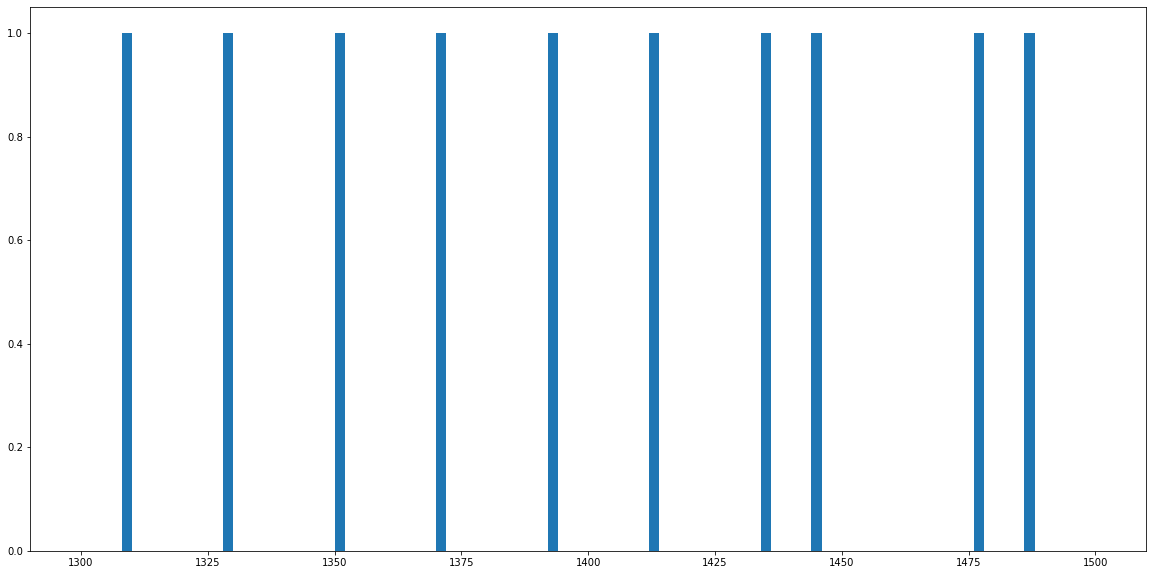

In [124]:
plt.hist(kymo[(kymo["fov"]==0)&kymo["row"]==1]["x (local)"]/microns,range=(1300,1500),bins=100)

In [58]:
fov = kymo[(kymo["fov"]==0)]
output = fov[(fov["x (local)"]<(1395*microns))&(fov["x (local)"]>(1380*microns))&(fov["y (local)"]<(1100*microns))&(fov["y (local)"]>(1000*microns))]

In [62]:
output

fov  row  trench      time (s) lane orientation  \
trenchid timepoints                                                    
174      131           0    1      68  78622.836661              top   
         132           0    1      68  79223.242261              top   
         133           0    1      68  79823.102101              top   
         134           0    1      68  80422.937701              top   
         135           0    1      68  81023.475301              top   
...                  ...  ...     ...           ...              ...   
175      126           0    1      69  75623.486701              top   
         127           0    1      69  76223.562037              top   
         128           0    1      69  76824.168733              top   
         129           0    1      69  77423.988325              top   
         130           0    1      69  78022.505197              top   

                      y (local)   x (local)   y (global)   x (global)  \
trenchid timepoints                                                     
174      131         332.671769  452.875435 -3912.128231 -6817.924565   
         132         332.671769  452.875435 -3912.328231 -6817.824565   
         133         332.671769  452.875435 -3912.228231 -6817.924565   
         134         332.671769  452.875435 -3912.228231 -6817.924565   
         135         332.671769  452.875435 -3912.128231 -6817.924565   
...                         ...         ...          ...          ...   
175      126         332.671769  452.550561 -3912.228231 -6818.249439   
         127         332.671769  452.550561 -3912.228231 -6818.349439   
         128         332.671769  452.550561 -3912.228231 -6818.349439   
         129         332.671769  452.550561 -3912.228231 -6818.349439   
         130         332.671769  452.550561 -3912.228231 -6818.349439   

                     File Index  File Trench Index  
trenchid timepoints                                 
174      131                  6                 24  
         132                  6                 24  
         133                  6                 24  
         134                  6                 24  
         135                  6                 24  
...                         ...                ...  
175      126                  7                  0  
         127                  7                  0  
         128                  7                  0  
         129                  7                  0  
         130                  7                  0  

[137 rows x 11 columns]

In [8]:
df = dd.read_parquet(headpath + "/lineage/output",engine='fastparquet')

/home/de64/miniconda3/envs/trenchripper/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [80]:
def compute_del_area(series):
    ttl_t = len(series["area"])
    del_areas = []
    for t in range(ttl_t-1):
        del_area = series["area"].values[t+1]/series["area"].values[t]
        del_areas.append(del_area)
    del_areas.append(-1)
    max_discont = np.max(del_areas)
    return max_discont

In [412]:
df = dd.read_parquet(headpath + "/lineage/output",engine='fastparquet')
trenchid_group = df.groupby(["trenchid","timepoints"])
max_cent_y = trenchid_group["Centroid Y"].idxmax()
max_cent_y_list = max_cent_y.compute().tolist()
mothers_df = df.loc[max_cent_y_list].persist()
area_groupby = mothers_df.groupby("trenchid")["area"]
peaks = area_groupby.apply(sp.signal.find_peaks,distance=3,prominence=3).compute()

first_peaks = []
ttl_peaks = []
for peak in peaks:
    if len(peak[0])>0:
        first_peaks.append(peak[0][0])
        ttl_peaks.append(sum(peak[0]>-1))
    else:
        first_peaks.append(-1)
        ttl_peaks.append(0)
first_peaks = pd.DataFrame({"lag time":first_peaks,"ttl peaks":ttl_peaks})
first_peaks.index = peaks.index

lag_df = mothers_df.join(first_peaks, on='trenchid').persist()
first_gen_df = lag_df.groupby("trenchid").apply(lambda g: g[g['timepoints'] <= g['lag time'].max()]).compute()
first_gen_df = first_gen_df.droplevel("trenchid")

max_discon = first_gen_df.groupby("trenchid").apply(compute_del_area)
max_discon = pd.DataFrame({"max discon":max_discon})
first_gen_df = first_gen_df.join(max_discon, on='trenchid')
first_gen_df = first_gen_df[first_gen_df["max discon"]<2.]

trenchid_groupby = first_gen_df.groupby('trenchid')
filtered_trenchids = trenchid_groupby["YFP mean_intensity"].mean()<2500.
filtered_trenchids = filtered_trenchids[filtered_trenchids].index.tolist()
lag_df_loss = first_gen_df[first_gen_df["trenchid"].isin(filtered_trenchids)]
loss_lag_times = lag_df_loss.groupby('trenchid')["lag time"].max()
lag_times = first_gen_df.groupby('trenchid')["lag time"].max()

file_indices = lag_df_loss.groupby(['File Index','File Trench Index'])['File Index'].min().values
trench_indices = lag_df_loss.groupby(['File Index','File Trench Index'])['File Trench Index'].min().values

/home/de64/miniconda3/envs/trenchripper/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: `meta` is not specified, inferred from partial data. Please provide `meta` if the result is unexpected.
  Before: .apply(func)
  After:  .apply(func, meta={'x': 'f8', 'y': 'f8'}) for dataframe result
  or:     .apply(func, meta=('x', 'f8'))            for series result
  import sys
/home/de64/miniconda3/envs/trenchripper/lib/python3.7/site-packages/ipykernel_launcher.py:22: UserWarning: `meta` is not specified, inferred from partial data. Please provide `meta` if the result is unexpected.
  Before: .apply(func)
  After:  .apply(func, meta={'x': 'f8', 'y': 'f8'}) for dataframe result
  or:     .apply(func, meta=('x', 'f8'))            for series result


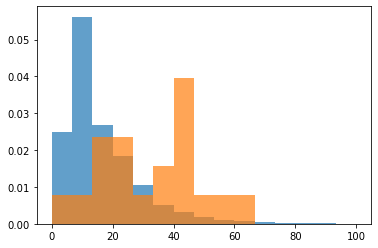

In [413]:
%matplotlib inline
plt.hist(lag_times,bins=15,range=(0,100),density=True,alpha=0.7)
plt.hist(loss_lag_times,bins=15,range=(0,100),density=True,alpha=0.7)
plt.show()

In [171]:
df = dd.read_parquet(headpath + "/lineage/output",engine='fastparquet')

first_tpt_df = df[df["timepoints"] == 0]
original_cell_ids = first_tpt_df["Global CellID"].compute().tolist()
original_cell_df = df[df['Global CellID'].isin(original_cell_ids)]

In [172]:
max_discon = original_cell_df.groupby("Global CellID").apply(compute_del_area)
max_discon = pd.DataFrame({"max discon":max_discon})
original_cell_df = original_cell_df.join(max_discon, on='Global CellID',rsuffix="_moo")
original_cell_df = original_cell_df[(original_cell_df["max discon"]>0.2)&(original_cell_df["max discon"]<2.)]
original_cell_df_pd = original_cell_df.compute()

/home/de64/miniconda3/envs/trenchripper/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: `meta` is not specified, inferred from partial data. Please provide `meta` if the result is unexpected.
  Before: .apply(func)
  After:  .apply(func, meta={'x': 'f8', 'y': 'f8'}) for dataframe result
  or:     .apply(func, meta=('x', 'f8'))            for series result
  """Entry point for launching an IPython kernel.


In [173]:
original_cell_df_pd

,File Index,File Trench Index,timepoints,CellID,Global CellID,Trench Score,Mother CellID,Daughter CellID 1,Daughter CellID 2,Sister CellID,...,fov,row,trench,time (s),lane orientation,y (local),x (local),y (global),x (global),max discon
index,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,0,0,-65.293441,-1,26,27,-1,...,0,0,0,24.190117,top,153.340893,0.649750,-4091.559107,-7270.250250,1.277778
1,0,0,0,1,1,-65.293441,-1,18,19,-1,...,0,0,0,24.190117,top,153.340893,0.649750,-4091.559107,-7270.250250,1.187500
2,0,0,0,2,2,-65.293441,-1,20,21,-1,...,0,0,0,24.190117,top,153.340893,0.649750,-4091.559107,-7270.250250,1.500000
3,0,0,0,3,3,-65.293441,-1,-1,-1,-1,...,0,0,0,24.190117,top,153.340893,0.649750,-4091.559107,-7270.250250,1.250000
4,0,0,0,4,4,-65.293441,-1,22,23,-1,...,0,0,0,24.190117,top,153.340893,0.649750,-4091.559107,-7270.250250,1.368421
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2400080000,0,24,8,0,240000,-74.340721,-1,240033,240034,-1,...,0,0,24,4824.349141,top,153.340893,83.492817,-4091.659107,-7187.407183,1.404255
2400090000,0,24,9,0,240000,-74.340721,-1,240033,240034,-1,...,0,0,24,5423.137237,top,153.340893,83.492817,-4091.659107,-7187.407183,1.404255
2400100000,0,24,10,0,240000,-74.340721,-1,240033,240034,-1,...,0,0,24,6023.179837,top,153.340893,83.492817,-4091.559107,-7187.307183,1.404255


In [175]:
cellids_groupby = original_cell_df_pd.groupby(['Global CellID'])
filtered_cellids = cellids_groupby["YFP mean_intensity"].mean()<2500.
low_signal_cells = filtered_cellids[filtered_cellids].index.tolist()
low_signal_cells_df = original_cell_df_pd[original_cell_df_pd["Global CellID"].isin(low_signal_cells)]

# grouped_signal_cells_df = low_signal_cells_df.groupby(['Global CellID'])
# low_norm_signal_cells = grouped_signal_cells_df.apply(lambda x: np.all((x['Normalized YFP'] < 0.2)))
# low_norm_signal_cells = low_norm_signal_cells[low_norm_signal_cells].index.tolist()
# low_norm_signal_cells_df = low_signal_cells_df[low_signal_cells_df["Global CellID"].isin(low_norm_signal_cells)]

grouped_signal_cells_df = low_signal_cells_df.groupby(['Global CellID'])
filtered_time = grouped_signal_cells_df["timepoints"].max()>0
final_cellids = filtered_time[filtered_time].index.tolist()
out_df = low_signal_cells_df[low_signal_cells_df["Global CellID"].isin(final_cellids)]
out_df = out_df[out_df["Daughter CellID 1"] != -1]
out_df = out_df[out_df["Daughter CellID 2"] != -1]

In [176]:
max_discon

,max discon
0,1.277778
1,1.187500
2,1.500000
3,1.250000
4,1.368421
...,...
390570,2.312500
390571,1.288889
390572,1.285714
390573,-1.000000


In [177]:
cellid_df = df.set_index("Global CellID")

In [178]:
daughter_1_df = cellid_df.loc[out_df["Daughter CellID 1"].values].compute()
daughter_2_df = cellid_df.loc[out_df["Daughter CellID 2"].values].compute()

In [179]:
init_tpt = daughter_1_df.groupby("Global CellID")["timepoints"].min()
init_tpt = pd.DataFrame({"init_tpt":init_tpt})
daughter_1_df = daughter_1_df.join(init_tpt, on='Global CellID')
daughter_1_df = daughter_1_df[daughter_1_df["timepoints"]==daughter_1_df["init_tpt"]]

In [180]:
init_tpt = daughter_2_df.groupby("Global CellID")["timepoints"].min()
init_tpt = pd.DataFrame({"init_tpt":init_tpt})
daughter_2_df = daughter_2_df.join(init_tpt, on='Global CellID')
daughter_2_df = daughter_2_df[daughter_2_df["timepoints"]==daughter_2_df["init_tpt"]]

In [181]:
ttl_daughter_area = daughter_1_df["area"].values+daughter_2_df["area"].values

In [182]:
out_df["ttl_daughter_area"] = ttl_daughter_area

In [183]:
init_tpt = out_df.groupby('Global CellID')['timepoints'].max()
init_tpt = pd.DataFrame({"init_tpt":init_tpt})
out_df = out_df.join(init_tpt, on='Global CellID')
out_df = out_df[out_df["timepoints"]==out_df["init_tpt"]]
out_df["area_ratio"] = (out_df["ttl_daughter_area"]/out_df["area"]).values

In [ ]:
out_df

In [189]:
out_df = out_df[out_df["area_ratio"]<2.]

In [190]:
out_df

,File Index,File Trench Index,timepoints,CellID,Global CellID,Trench Score,Mother CellID,Daughter CellID 1,Daughter CellID 2,Sister CellID,...,time (s),lane orientation,y (local),x (local),y (global),x (global),max discon,ttl_daughter_area,init_tpt,area_ratio
index,,,,,,,,,,,,,,,,,,,,,


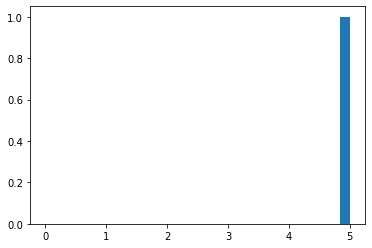

In [184]:
plt.hist(out_df["area_ratio"],bins=30,range=(0,5))
plt.show()

In [185]:
lag_times = original_cell_df_pd.groupby(['Global CellID'])["timepoints"].max()
loss_lag_times = out_df.groupby(['Global CellID'])["timepoints"].max()

In [186]:
loss_lag_times

Global CellID
50002    2
Name: timepoints, dtype: int64

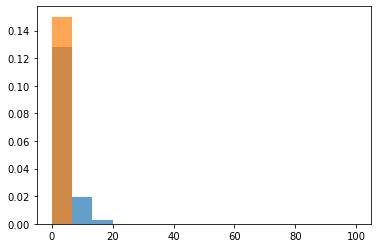

In [188]:
%matplotlib inline
plt.hist(lag_times,bins=15,range=(0,100),density=True,alpha=0.7)
plt.hist(loss_lag_times,bins=15,range=(0,100),density=True,alpha=0.7)
plt.show()

In [136]:
file_indices = out_df.groupby(['File Index','File Trench Index'])['File Index'].min().values
trench_indices = out_df.groupby(['File Index','File Trench Index'])['File Trench Index'].min().values

In [137]:
file_indices

array([   3,    7,    7,   16,   25,   38,   44,   86,  103,  120,  127,
        131,  165,  180,  193,  198,  217,  224,  228,  233,  249,  277,
        277,  317,  352,  378,  419,  427,  432,  457,  468,  472,  485,
        487,  493,  516,  527,  535,  544,  545,  553,  578,  579,  580,
        584,  590,  598,  598,  636,  664,  682,  685,  705,  718,  730,
        744,  828,  836,  855,  872,  882,  914,  921,  958,  975,  996,
       1005, 1011, 1012, 1013, 1021, 1021, 1021, 1021, 1021, 1021, 1021,
       1022, 1022, 1022, 1028, 1029, 1031, 1033, 1132, 1180, 1212, 1242,
       1251, 1261, 1284, 1315, 1317, 1344, 1348, 1369, 1387, 1388, 1389,
       1391, 1402, 1403, 1403, 1403, 1405, 1408, 1415, 1417, 1417, 1440,
       1453, 1465])

In [138]:
trench_indices

array([23,  2, 21,  3,  2, 21,  9, 10, 13, 23, 13, 15,  9, 20, 21,  5, 10,
        6, 12, 22, 10,  1,  6, 14, 17, 10,  4, 14,  3,  0,  5,  6, 24, 22,
       24,  4, 10, 13, 19, 17, 18,  4, 11, 15, 18, 13,  7, 17, 12,  8, 20,
       10, 13, 20,  2, 20, 17, 23,  9, 14, 19, 21,  0, 21, 19,  9, 17,  8,
        2, 11,  0,  1,  2,  3,  4,  5, 14,  1,  2,  8,  7, 11,  3, 21, 22,
       20,  4, 21, 19, 21, 12, 18, 15, 13,  6,  2, 22,  2, 10,  4, 21, 20,
       22, 24, 19,  1, 21,  8, 22,  5,  9, 20])

In [35]:
test = df.loc[:100].compute()

In [39]:
test["Centroid Y"]

index
0     54.451837
1     50.668862
2     46.518007
3     43.912240
4     38.242402
5     35.573788
6     33.095308
7     29.842069
8     25.808052
9     21.986378
10    18.281590
11    15.706989
Name: Centroid Y, dtype: float64

In [12]:
def filter_df(df,query_list,client=False,repartition=False):
    #filter_list must be in df.query format (see pandas docs)
    
    #returns persisted dataframe either in cluster or local
    
    compiled_query = ' and '.join(query_list)
    out_df = df.query(compiled_query)
    if client:
        out_df = client.daskclient.persist(out_df)
    else:
        out_df = out_df.persist()
        
    if repartition:
        init_size = len(df)
        final_size = len(out_df)
        ratio = init_size//final_size
        out_df = out_df.repartition(npartitions=(df.npartitions // ratio) + 1)
        
        if client:
            out_df = client.daskclient.persist(out_df)
        else:
            out_df = out_df.persist()

    return out_df

In [9]:
trenchid_group = df.groupby(["trenchid","timepoints"])

In [10]:
max_cent_y = trenchid_group["Centroid Y"].idxmax()

In [11]:
max_cent_y_list = max_cent_y.compute().tolist()

In [54]:
max_cent_y_list

[0,
 10000,
 20000,
 30000,
 40000,
 50000,
 60000,
 70026,
 80026,
 90032,
 100032,
 110032,
 120032,
 130044,
 140044,
 150054,
 160054,
 170054,
 180054,
 190054,
 200070,
 210070,
 220070,
 230070,
 240082,
 250082,
 260082,
 270090,
 280090,
 290090,
 300098,
 310098,
 320098,
 330098,
 340098,
 350098,
 360098,
 370098,
 380098,
 390098,
 400127,
 410127,
 420133,
 430133,
 440144,
 450144,
 460144,
 470144,
 480153,
 490157,
 500157,
 510157,
 520172,
 530172,
 540178,
 550178,
 560184,
 570184,
 580184,
 590191,
 600199,
 610199,
 620201,
 630203,
 640203,
 650203,
 660208,
 670212,
 680217,
 690217,
 700221,
 710224,
 720224,
 730224,
 740230,
 750234,
 760234,
 770240,
 780240,
 790240,
 800242,
 810249,
 820249,
 830249,
 840249,
 850256,
 860264,
 870264,
 880264,
 890264,
 900269,
 910271,
 920274,
 930274,
 940274,
 950274,
 960274,
 970291,
 980291,
 990301]

In [12]:
mothers_df = df.loc[max_cent_y_list].persist()

In [13]:
area_groupby = mothers_df.groupby("trenchid")["area"]

In [111]:
peaks = area_groupby.apply(sp.signal.find_peaks,distance=3,prominence=3).compute()

/home/de64/miniconda3/envs/trenchripper/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: `meta` is not specified, inferred from partial data. Please provide `meta` if the result is unexpected.
  Before: .apply(func)
  After:  .apply(func, meta={'x': 'f8', 'y': 'f8'}) for dataframe result
  or:     .apply(func, meta=('x', 'f8'))            for series result
  """Entry point for launching an IPython kernel.


In [142]:
len(ttl_peaks)

33199

In [143]:
first_peaks = []
ttl_peaks = []
for peak in peaks:
    if len(peak[0])>0:
        first_peaks.append(peak[0][0])
        ttl_peaks.append(sum(peak[0]>-1))
    else:
        first_peaks.append(-1)
        ttl_peaks.append(0)
first_peaks = pd.DataFrame({"lag time":first_peaks,"ttl peaks":ttl_peaks})
first_peaks.index = peaks.index

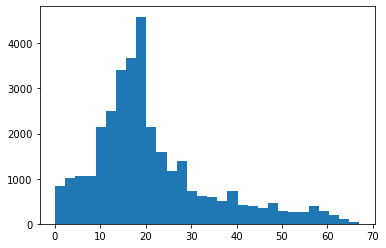

In [145]:
%matplotlib inline
plt.hist(first_peaks["ttl peaks"],bins=30)
plt.show()

In [114]:
len(first_peaks)

33199

In [194]:
trenchid_groupby["lag time"].min().compute()

trenchid
0         6
1         2
2        16
3         6
4         8
         ..
36641     6
36642     7
36643    10
36644    13
36645     8
Name: lag time, Length: 33199, dtype: int64

In [214]:
temp_df = lag_df.set_index("trenchid").compute()

In [225]:
first_gen_df

File Index  File Trench Index  timepoints  CellID  \
trenchid index                                                                 
39       1001400000000              1                 14           0       0   
         1001400010000              1                 14           1       0   
         1001400020000              1                 14           2       0   
         1001400030000              1                 14           3       0   
         1001400040000              1                 14           4       0   
...                               ...                ...         ...     ...   
36561    1462001100110030        1462                 11          11      30   
         1462001100120040        1462                 11          12      40   
         1462001100130040        1462                 11          13      40   
         1462001100140040        1462                 11          14      40   
         1462001100150040        1462                 11          15      40   

                           Global CellID  Trench Score  Mother CellID  \
trenchid index                                                          
39       1001400000000         100140000    -77.232738             -1   
         1001400010000         100140000    -77.232738             -1   
         1001400020000         100140000    -77.232738             -1   
         1001400030000         100140000    -77.232738             -1   
         1001400040000         100140000    -77.232738             -1   
...                                  ...           ...            ...   
36561    1462001100110030   146200110030    -77.000130   146200110024   
         1462001100120040   146200110040    -77.000130   146200110030   
         1462001100130040   146200110040    -77.000130   146200110030   
         1462001100140040   146200110040    -77.000130   146200110030   
         1462001100150040   146200110040    -77.000130   146200110030   

                           Daughter CellID 1  Daughter CellID 2  \
trenchid index                                                    
39       1001400000000             100140069          100140070   
         1001400010000             100140069          100140070   
         1001400020000             100140069          100140070   
         1001400030000             100140069          100140070   
         1001400040000             100140069          100140070   
...                                      ...                ...   
36561    1462001100110030       146200110040       146200110041   
         1462001100120040       146200110054       146200110055   
         1462001100130040       146200110054       146200110055   
         1462001100140040       146200110054       146200110055   
         1462001100150040       146200110054       146200110055   

                           Sister CellID  ...  row  trench     time (s)  \
trenchid index                            ...                             
39       1001400000000                -1  ...    0      39    24.190117   
         1001400010000                -1  ...    0      39   623.375077   
         1001400020000                -1  ...    0      39  1223.494525   
         1001400030000                -1  ...    0      39  1823.567341   
         1001400040000                -1  ...    0      39  2424.008173   
...                                  ...  ...  ...     ...          ...   
36561    1462001100110030   146200110031  ...    1     103  7051.897669   
         1462001100120040   146200110041  ...    1     103  7649.550181   
         1462001100130040   146200110041  ...    1     103  8251.706485   
         1462001100140040   146200110041  ...    1     103  8854.411765   
         1462001100150040   146200110041  ...    1     103  9455.619613   

                           lane orientation   y (local)   x (local)  \
trenchid index                                                        
39       1001400000000                  top  1

In [208]:
lag_time_list = trenchid_groupby["lag time"].min().compute()

In [216]:
lag_time_list

trenchid
0         6
1         2
2        16
3         6
4         8
         ..
36641     6
36642     7
36643    10
36644    13
36645     8
Name: lag time, Length: 33199, dtype: int64

In [218]:
first_gen_df = lag_df.groupby("trenchid").apply(lambda g: g[g['timepoints'] <= g['lag time'].max()]).compute()

In [221]:
test = trenchid_groupby.apply(lambda g: g[g['timepoints'] <= g['lag time'].max()]).compute()

/home/de64/miniconda3/envs/trenchripper/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: `meta` is not specified, inferred from partial data. Please provide `meta` if the result is unexpected.
  Before: .apply(func)
  After:  .apply(func, meta={'x': 'f8', 'y': 'f8'}) for dataframe result
  or:     .apply(func, meta=('x', 'f8'))            for series result
  """Entry point for launching an IPython kernel.


In [223]:
test[:30]

File Index  File Trench Index  timepoints  CellID  \
trenchid index                                                              
39       1001400000000           1                 14           0       0   
         1001400010000           1                 14           1       0   
         1001400020000           1                 14           2       0   
         1001400030000           1                 14           3       0   
         1001400040000           1                 14           4       0   
         1001400050000           1                 14           5       0   
         1001400060000           1                 14           6       0   
         1001400070000           1                 14           7       0   
         1001400080000           1                 14           8       0   
         1001400090000           1                 14           9       0   
         1001400100000           1                 14          10       0   
         1001400110000           1                 14          11       0   
         1001400120000           1                 14          12       0   
         1001400130000           1                 14          13       0   
         1001400140000           1                 14          14       0   
         1001400150000           1                 14          15       0   
         1001400160000           1                 14          16       0   
         1001400170000           1                 14          17       0   
         1001400180000           1                 14          18       0   
         1001400190000           1                 14          19       0   
         1001400200000           1                 14          20       0   
         1001400210000           1                 14          21       0   
         1001400220000           1                 14          22       0   
162      6001200000000           6                 12           0       0   
         6001200010000           6                 12           1       0   
         6001200020000           6                 12           2       0   
         6001200030000           6                 12           3       0   
         6001200040000           6                 12           4       0   
176      7000100000000           7                  1           0       0   
         7000100010000           7                  1           1       0   

                        Global CellID  Trench Score  Mother CellID  \
trenchid index                                                       
39       1001400000000      100140000    -77.232738             -1   
         1001400010000      100140000    -77.232738             -1   
         1001400020000      100140000    -77.232738             -1   
         1001400030000      100140000    -77.232738             -1   
         1001400040000      100140000    -77.232738             -1   
         1001400050000      100140000    -77.232738             -1   
         1001400060000      100140000    -77.232738             -1   
         1001400070000      100140000    -77.232738             -1   
         1001400080000      100140000    -77.232738             -1   
         1001400090000      100140000    -77.232738             -1   
         1001400100000      100140000    -77.232738             -1   
         1001400110000      100140000    -77.232738             -1   
         1001400120000      100140000    -77.232738             -1   
         1001400130000      100140000    -77.232738             -1   
         1001400140000      100140000    -77.232738             -1   
         1001400150000      100140000    -77.232738             -1   
         1001400160000      100140000    -77.232738             -1   
         1001400170000      100140000    -77.232738             -1   
         1001400180000      100140000    -77.232738             -1   
         1001400190000      100140000    -77.232738             -1   
         1001400200

In [242]:
filtered_trenchids = trenchid_groupby["YFP mean_intensity"].mean()<2500.

In [306]:
for t in range(1):
    print(t)

0


In [321]:
def compute_del_area(series):
    ttl_t = len(series["area"])
    del_areas = []
    for t in range(ttl_t-1):
        del_area = series["area"].values[t+1]/series["area"].values[t]
        del_areas.append(del_area)
    del_areas.append(-1)
    max_discont = np.max(del_areas)
    return max_discont

In [ ]:
first_peaks = []
ttl_peaks = []
for peak in peaks:
    if len(peak[0])>0:
        first_peaks.append(peak[0][0])
        ttl_peaks.append(sum(peak[0]>-1))
    else:
        first_peaks.append(-1)
        ttl_peaks.append(0)

first_peaks = pd.DataFrame({"lag time":first_peaks,"ttl peaks":ttl_peaks})
first_peaks.index = peaks.index

In [329]:
max_discont = first_gen_df.groupby("trenchid").apply(compute_del_area)
max_discont_filter = max_discont<1.75

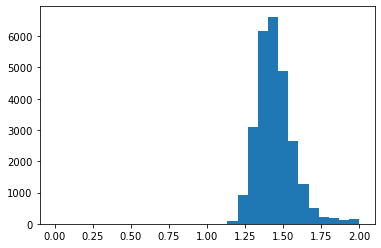

In [330]:
%matplotlib inline
plt.hist(max_discont,bins=30,range=(0,2))
plt.show()

In [337]:
lag_df = mothers_df.join(first_peaks, on='trenchid').persist()
first_gen_df = lag_df.groupby("trenchid").apply(lambda g: g[g['timepoints'] <= g['lag time'].max()]).compute()
first_gen_df = first_gen_df.droplevel("trenchid")

max_discon = first_gen_df.groupby("trenchid").apply(compute_del_area)
max_discon = pd.DataFrame({"max discon":max_discon})
first_gen_df = first_gen_df.join(max_discon, on='trenchid')
first_gen_df = first_gen_df[first_gen_df["max discon"]<2.]

# lag_df = lag_df[(lag_df["ttl peaks"]>15)&(lag_df["ttl peaks"]<45)]
# trenchid_groupby = lag_df[lag_df["timepoints"]==0].groupby('trenchid')
# filtered_trenchids = trenchid_groupby.apply(lambda x: np.all((x['YFP mean_intensity'] < 2500.)))
# trenchid_groupby = lag_df.groupby('trenchid')
# filtered_trenchids = trenchid_groupby.apply(lambda x: np.all((x['YFP mean_intensity'] < 3000.)))
trenchid_groupby = first_gen_df.groupby('trenchid')
filtered_trenchids = trenchid_groupby["YFP mean_intensity"].mean()<2500.
filtered_trenchids = filtered_trenchids[filtered_trenchids].index.tolist()
lag_df_loss = first_gen_df[first_gen_df["trenchid"].isin(filtered_trenchids)]
loss_lag_times = lag_df_loss.groupby('trenchid')["lag time"].max()
lag_times = first_gen_df.groupby('trenchid')["lag time"].max()

/home/de64/miniconda3/envs/trenchripper/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: `meta` is not specified, inferred from partial data. Please provide `meta` if the result is unexpected.
  Before: .apply(func)
  After:  .apply(func, meta={'x': 'f8', 'y': 'f8'}) for dataframe result
  or:     .apply(func, meta=('x', 'f8'))            for series result
  


In [338]:
filtered_trenchids

[1109,
 3023,
 3188,
 5606,
 6235,
 9460,
 10064,
 10689,
 12197,
 14515,
 19507,
 20765,
 22871,
 23971,
 25707,
 27140,
 32112,
 34735,
 34779,
 36334]

In [344]:
file_indices = lag_df_loss.groupby(['File Index','File Trench Index'])['File Index'].min().values
trench_indices = lag_df_loss.groupby(['File Index','File Trench Index'])['File Trench Index'].min().values

In [340]:
file_indices
trench_indices

array([ 9, 23, 13,  6, 10, 10, 14, 14, 22, 15,  7, 15, 21, 21,  7, 15, 12,
       10,  4,  9])

In [341]:
trench_indices

array([ 9, 23, 13,  6, 10, 10, 14, 14, 22, 15,  7, 15, 21, 21,  7, 15, 12,
       10,  4,  9])

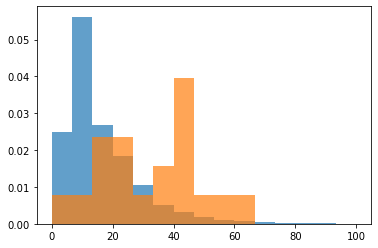

In [386]:
%matplotlib inline
plt.hist(lag_times,bins=15,range=(0,100),density=True,alpha=0.7)
plt.hist(loss_lag_times,bins=15,range=(0,100),density=True,alpha=0.7)
plt.show()

In [39]:
lag_times

Dask Series Structure:
npartitions=1
    int64
      ...
Name: lag time, dtype: int64
Dask Name: series-groupby-max-agg, 80 tasks

In [25]:
lag_df.compute()

filtered_cellids = cellids.apply(lambda x: np.all((x['YFP mean_intensity'] < 5000.)))
low_signal_cells = filtered_cellids[filtered_cellids].index.tolist()
low_signal_cells_df = original_cell_df_pd[original_cell_df_pd["Global CellID"].isin(low_signal_cells)]

,File Index,File Trench Index,timepoints,CellID,Global CellID,Trench Score,Mother CellID,Daughter CellID 1,Daughter CellID 2,Sister CellID,...,fov,row,trench,time (s),lane orientation,y (local),x (local),y (global),x (global),lag time
index,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,0,0,-65.293441,-1,26,27,-1,...,0,0,0,24.190117,top,153.340893,0.649750,-4091.559107,-7270.250250,6
10000,0,0,1,0,0,-65.293441,-1,26,27,-1,...,0,0,0,623.375077,top,153.340893,0.649750,-4091.559107,-7270.150250,6
20000,0,0,2,0,0,-65.293441,-1,26,27,-1,...,0,0,0,1223.494525,top,153.340893,0.649750,-4091.559107,-7270.150250,6
30000,0,0,3,0,0,-65.293441,-1,26,27,-1,...,0,0,0,1823.567341,top,153.340893,0.974624,-4091.659107,-7269.825376,6
40000,0,0,4,0,0,-65.293441,-1,26,27,-1,...,0,0,0,2424.008173,top,153.340893,0.974624,-4091.559107,-7269.825376,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1465002001530480,1465,20,153,480,146500200480,-76.613918,146500200468,-1,-1,146500200481,...,70,1,187,92264.450581,top,258.600320,659.170917,5253.500320,8040.470917,5
1465002001540480,1465,20,154,480,146500200480,-76.613918,146500200468,-1,-1,146500200481,...,70,1,187,92846.681413,top,258.600320,659.170917,5253.600320,8040.370917,5
1465002001550480,1465,20,155,480,146500200480,-76.613918,146500200468,-1,-1,146500200481,...,70,1,187,93450.011437,top,258.600320,659.170917,5253.500320,8040.370917,5


In [27]:
lag_df_loss_idx

[10689, 6235, 27140, 9460, 1109, 17638, 34779]

In [ ]:
lag_df_loss_idx = lag_df.apply(lambda x: np.all((x['YFP mean_intensity'] < 2500.)))
lag_df_loss_idx = lag_df_loss_idx[lag_df_loss_idx].index.tolist()
lag_df_loss = lag_df_loss[lag_df_loss["Global CellID"].isin(lag_df_loss_idx)]

In [111]:
first_peaks

[6]

In [ ]:
plt.hist(first_peaks)
plt.show()

In [98]:
sp.signal.find_peaks()

TypeError: find_peaks() missing 1 required positional argument: 'x'

In [99]:
area_groupby.app

AttributeError: 'SeriesGroupBy' object has no attribute 'app'

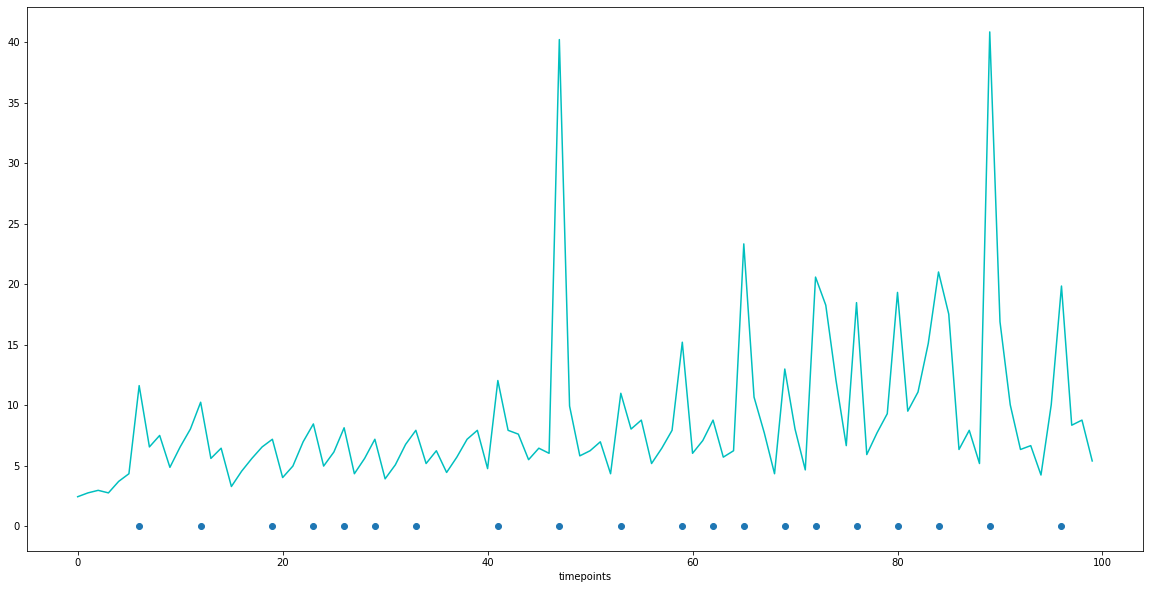

In [100]:
pivot_df = mothers_df.pivot(index='timepoints', columns='trenchid', values='area')
pivot_df.plot(c="c",legend=False)
plt.scatter(peaks.values[0][0],np.repeat(0,len(peaks.values[0][0])))

In [14]:
first_tpt_df = df[df["timepoints"] == 0]
original_cell_ids = first_tpt_df["Global CellID"].compute().tolist()
original_cell_df = df[df['Global CellID'].isin(original_cell_ids)]
original_cell_df_pd = original_cell_df.compute()

IndexError: list index out of range

In [ ]:
original_cell_df

In [12]:
original_cell_df["Normalized YFP"] = original_cell_df["YFP mean_intensity"]/original_cell_df["mCherry mean_intensity"]

In [13]:
original_cell_df_pd = original_cell_df.compute()

In [14]:
original_cell_df_pd.to_pickle("./original_cell_df.pkl")

In [6]:
import pandas as pd

In [7]:
original_cell_df_pd = pd.read_pickle("./original_cell_df.pkl")
# original_cell_df = dd.from_pandas(original_cell_df_pd,npartitions=50)

In [8]:
from matplotlib import pyplot as plt

In [9]:
original_cell_df_pd.loc[:1000]

,index,File Index,File Trench Index,timepoints,CellID,Global CellID,Trench Score,Mother CellID,Daughter CellID 1,Daughter CellID 2,...,fov,row,trench,time (s),lane orientation,y (local),x (local),y (global),x (global),Normalized YFP
index,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,0,0,0,-65.293441,-1,26,27,...,0,0,0,24.190117,top,153.340893,0.64975,-4091.559107,-7270.25025,1.089396
1,1,0,0,0,1,1,-65.293441,-1,18,19,...,0,0,0,24.190117,top,153.340893,0.64975,-4091.559107,-7270.25025,0.872020
2,2,0,0,0,2,2,-65.293441,-1,20,21,...,0,0,0,24.190117,top,153.340893,0.64975,-4091.559107,-7270.25025,0.850810
3,3,0,0,0,3,3,-65.293441,-1,-1,-1,...,0,0,0,24.190117,top,153.340893,0.64975,-4091.559107,-7270.25025,1.135632
4,4,0,0,0,4,4,-65.293441,-1,22,23,...,0,0,0,24.190117,top,153.340893,0.64975,-4091.559107,-7270.25025,1.069282
5,5,0,0,0,5,5,-65.293441,-1,-1,-1,...,0,0,0,24.190117,top,153.340893,0.64975,-4091.559107,-7270.25025,0.874212
6,6,0,0,0,6,6,-65.293441,-1,12,13,...,0,0,0,24.190117,top,153.340893,0.64975,-4091.559107,-7270.25025,0.704372
7,7,0,0,0,7,7,-65.293441,-1,-1,-1,...,0,0,0,24.190117,top,153.340893,0.64975,-4091.559107,-7270.25025,0.692164
8,8,0,0,0,8,8,-65.293441,-1,-1,-1,...,0,0,0,24.190117,top,153.340893,0.64975,-4091.559107,-7270.25025,0.672480


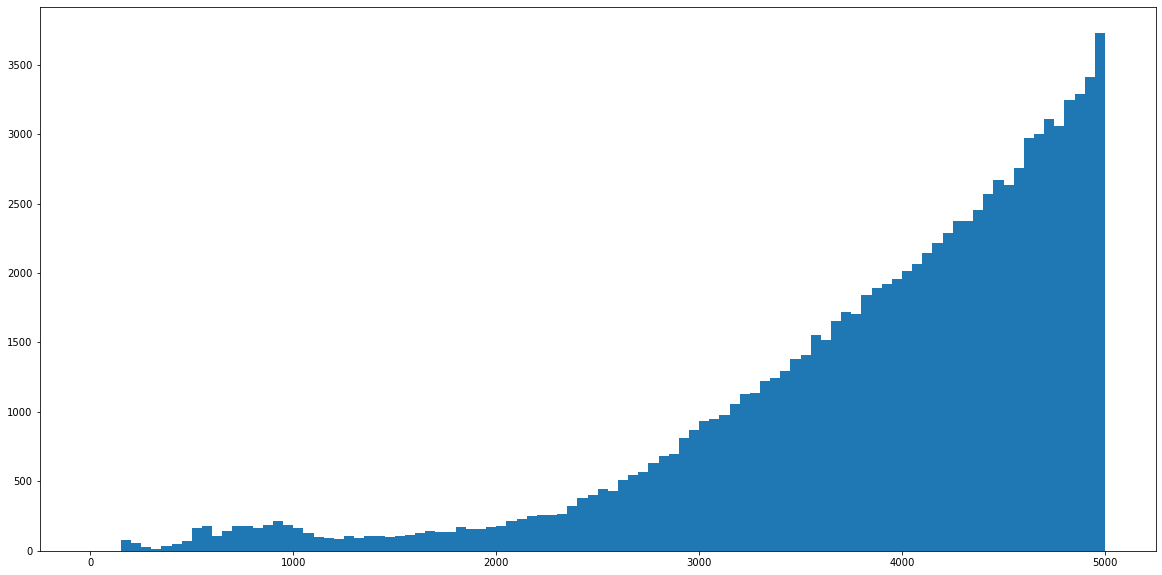

In [10]:
plt.hist(original_cell_df_pd["YFP mean_intensity"],bins=100,range=(0,5000))
plt.show()

In [11]:
import numpy as np

In [12]:
# cellids = original_cell_df.groupby(['Global CellID'])

In [13]:
cellids = original_cell_df_pd.groupby(['Global CellID'])

In [14]:
len(cellids)

390575

In [15]:
filtered_cellids = cellids.apply(lambda x: np.all((x['YFP mean_intensity'] < 5000.)))
low_signal_cells = filtered_cellids[filtered_cellids].index.tolist()
low_signal_cells_df = original_cell_df_pd[original_cell_df_pd["Global CellID"].isin(low_signal_cells)]

# grouped_signal_cells_df = low_signal_cells_df.groupby(['Global CellID'])
# low_norm_signal_cells = grouped_signal_cells_df.apply(lambda x: np.all((x['Normalized YFP'] < 0.2)))
# low_norm_signal_cells = low_norm_signal_cells[low_norm_signal_cells].index.tolist()
# low_norm_signal_cells_df = low_signal_cells_df[low_signal_cells_df["Global CellID"].isin(low_norm_signal_cells)]

grouped_signal_cells_df = low_signal_cells_df.groupby(['Global CellID'])
filtered_time = grouped_signal_cells_df["timepoints"].max()>0
final_cellids = filtered_time[filtered_time].index.tolist()
out_df = low_signal_cells_df[low_signal_cells_df["Global CellID"].isin(final_cellids)]
out_df = out_df[out_df["Daughter CellID 1"] != -1]


In [16]:
mother_df = out_df[out_df["CellID"]==0]

In [17]:
out_df[:50][["File Index", "File Trench Index", "trenchid"]]

,File Index,File Trench Index,trenchid
index,,,
400000004,0,4,4
400010004,0,4,4
400020004,0,4,4
500000002,0,5,5
500010002,0,5,5
500020002,0,5,5
1000200000002,1,2,27
1000200010002,1,2,27
1000200020002,1,2,27


In [18]:
max_tpts = mother_df.groupby(['Global CellID'])["timepoints"].max()

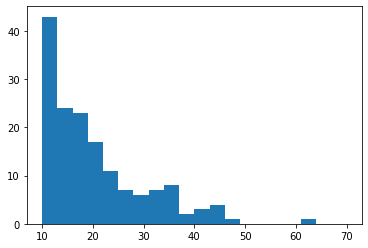

In [25]:
%matplotlib inline
plt.hist(max_tpts,bins=20,range=(10,70))
plt.show()

In [76]:
len(out_df)

849

In [20]:
out_df[:50]

,index,File Index,File Trench Index,timepoints,CellID,Global CellID,Trench Score,Mother CellID,Daughter CellID 1,Daughter CellID 2,...,fov,row,trench,time (s),lane orientation,y (local),x (local),y (global),x (global),Normalized YFP
index,,,,,,,,,,,,,,,,,,,,,
400000004,400000004,0,4,0,4,40004,-73.355283,-1,40015,40016,...,0,0,4,24.190117,top,153.340893,14.619365,-4091.559107,-7256.280635,0.458472
400010004,400010004,0,4,1,4,40004,-73.355283,-1,40015,40016,...,0,0,4,623.375077,top,153.340893,14.619365,-4091.559107,-7256.180635,0.474936
400020004,400020004,0,4,2,4,40004,-73.355283,-1,40015,40016,...,0,0,4,1223.494525,top,153.340893,14.619365,-4091.559107,-7256.180635,0.502638
500000002,500000002,0,5,0,2,50002,-71.312399,-1,50007,50008,...,0,0,5,24.190117,top,153.340893,18.192987,-4091.559107,-7252.707013,0.353474
500010002,500010002,0,5,1,2,50002,-71.312399,-1,50007,50008,...,0,0,5,623.375077,top,153.340893,18.192987,-4091.559107,-7252.607013,0.235811
500020002,500020002,0,5,2,2,50002,-71.312399,-1,50007,50008,...,0,0,5,1223.494525,top,153.340893,18.192987,-4091.559107,-7252.607013,0.230845
1000200000002,1000200000002,1,2,0,2,100020002,-77.725671,-1,100020010,100020011,...,0,0,27,24.190117,top,153.340893,93.563935,-4091.559107,-7177.336065,0.577356
1000200010002,1000200010002,1,2,1,2,100020002,-77.725671,-1,100020010,100020011,...,0,0,27,623.375077,top,153.340893,93.563935,-4091.559107,-7177.236065,0.671282
1000200020002,1000200020002,1,2,2,2,100020002,-77.725671,-1,100020010,100020011,...,0,0,27,1223.494525,top,153.340893,93.563935,-4091.559107,-7177.236065,0.780905


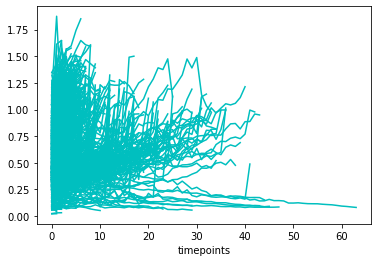

In [21]:
pivot_df = out_df.pivot(index='timepoints', columns='Global CellID', values='Normalized YFP')
time_pivot_df = out_df.pivot(index='Global CellID', columns='timepoints', values='Normalized YFP')
mean_in_time = time_pivot_df.mean()
pivot_df.plot(c="c",legend=False)
# plt.plot(mean_in_time,c="r")

In [ ]:
original_cell_df_pd["pos x"] = (original_cell_df_pd["x (local)"] + original_cell_df_pd["centroid x"])/microns
original_cell_df_pd["pos y"] = (original_cell_df_pd["y (local)"] + original_cell_df_pd["centroid y"])/microns

In [ ]:
original_cell_df_pd["fov"]==0

In [ ]:
original_cell_df_pd[(original_cell_df_pd["fov"]==0)&(original_cell_df_pd["timepoints"]==0)&(original_cell_df_pd["pos y"]>1000)&(original_cell_df_pd["pos y"]<1200)&(original_cell_df_pd["pos x"]>1300)&(original_cell_df_pd["pos x"]<1500)]

In [ ]:
from matplotlib import pyplot as plt
plt.hist(original_cell_df_pd[(original_cell_df_pd["fov"]==0)&(original_cell_df_pd["timepoints"]==0)&(original_cell_df_pd["pos y"]>1000)&(original_cell_df_pd["pos y"]<1200)]["pos x"],bins=30,range=(1300,1500))

##### Note

Try to get traces of normalized YFP for each cell and plot them...

In [46]:
from matplotlib import pyplot as plt

In [47]:


# yfp_groupby = original_cell_df.groupby(['Global CellID'])["Normalized YFP"]
# time_groupby = original_cell_df.groupby(['Global CellID'])["timepoints"]
cell_groupby = original_cell_df_pd.groupby(['Global CellID'])

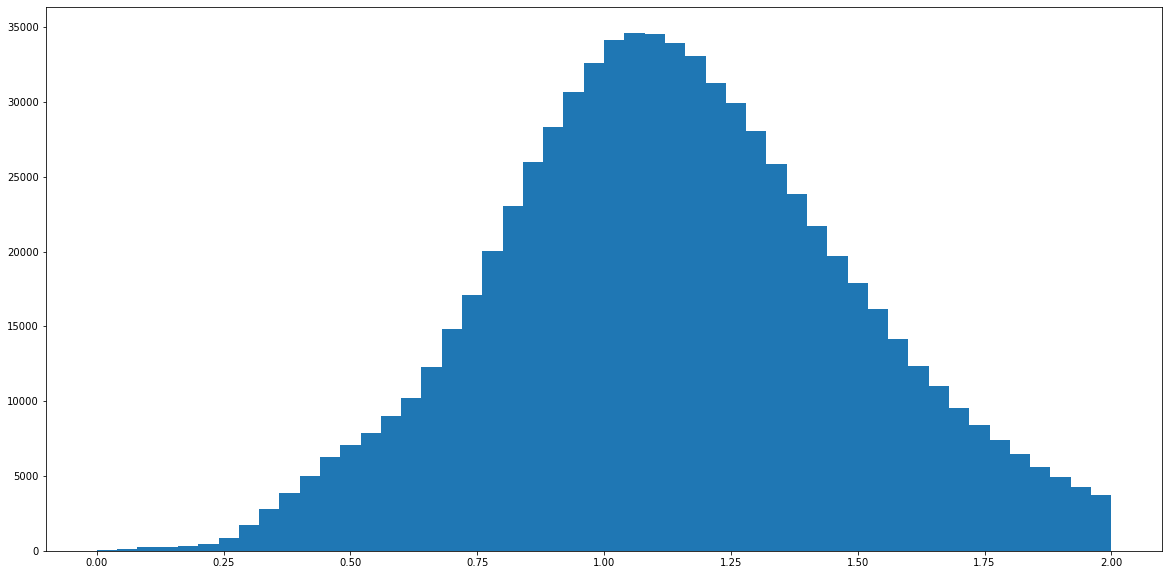

In [48]:
plt.hist(original_cell_df_pd["Normalized YFP"],range=(0,2),bins=50)
plt.show()

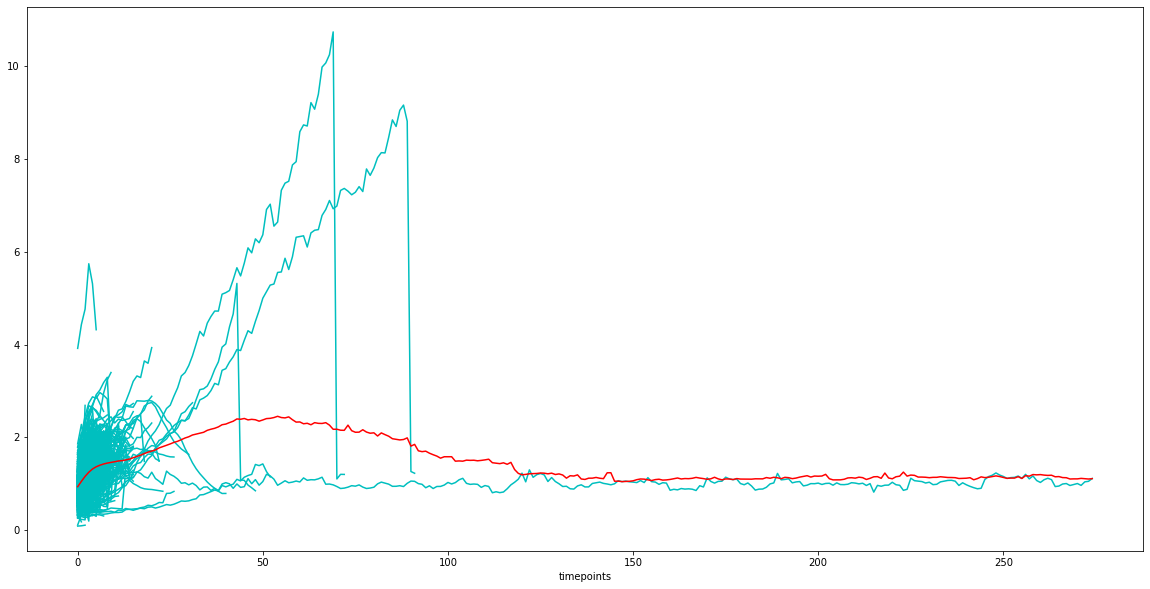

In [57]:
pivot_df = original_cell_df_pd.pivot(index='timepoints', columns='Global CellID', values='Normalized YFP')
time_pivot_df = original_cell_df_pd.pivot(index='Global CellID', columns='timepoints', values='Normalized YFP')
mean_in_time = time_pivot_df.mean()
pivot_df.plot(c="c",legend=False)
plt.plot(mean_in_time,c="r")

timepoints
0      0.935039
1      1.050120
2      1.157604
3      1.247051
4      1.317015
         ...   
270    1.103812
271    1.114370
272    1.108353
273    1.100729
274    1.108846
Length: 275, dtype: float64

In [ ]:
original_cell_df.groupby(['Global CellID'])[""]

In [99]:
first_tpt_idx = original_cell_df.groupby(['Global CellID'])['timepoints'].idxmin().compute()

In [100]:
last_tpt_idx = original_cell_df.groupby(['Global CellID'])['timepoints'].idxmax().compute()

In [102]:
cell_first_tpt_df = original_cell_df.loc[first_tpt_idx.tolist()].set_index('Global CellID').persist()
cell_last_tpt_df = original_cell_df.loc[last_tpt_idx.tolist()].set_index('Global CellID').persist()

In [103]:
cell_first_tpt_df

,index,File Index,File Trench Index,timepoints,CellID,Trench Score,Mother CellID,Daughter CellID 1,Daughter CellID 2,Sister CellID,centroid y,centroid x,area,mCherry mean_intensity,YFP mean_intensity,trenchid,fov,row,trench,time (s),lane orientation,y (local),x (local),y (global),x (global)
npartitions=16,,,,,,,,,,,,,,,,,,,,,,,,,
110000,int64,int64,int64,int64,int64,float64,int64,int64,int64,int64,float64,float64,float64,float64,float64,int64,int64,int64,int64,float64,object,float64,float64,float64,float64
6100150000,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83100130000,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92500090008,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [88]:
first_div_time = original_cell_df.groupby(['Global CellID'])['timepoints'].max().compute()

In [288]:
from matplotlib import pyplot as plt

In [302]:
yfp_signal_first = cell_first_tpt_df["YFP mean_intensity"].compute()
yfp_signal_last = cell_last_tpt_df["YFP mean_intensity"].compute()
mcherry_signal_first = cell_first_tpt_df["mCherry mean_intensity"].compute()
mcherry_signal_last = cell_last_tpt_df["mCherry mean_intensity"].compute()
normalized_yfp_first = yfp_signal_first/mcherry_signal_first
normalized_yfp_last = yfp_signal_last/mcherry_signal_last
normalized_signal_ratio = normalized_yfp_last/normalized_yfp_first

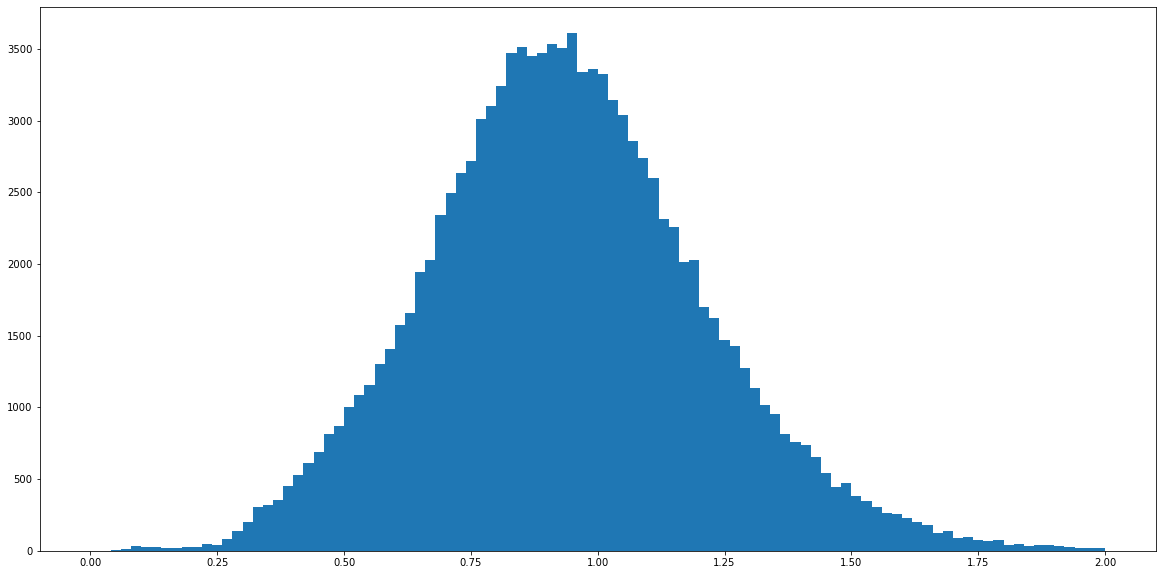

In [299]:
plt.hist(normalized_yfp_first.values,range=(0,2),bins=100)
plt.show()

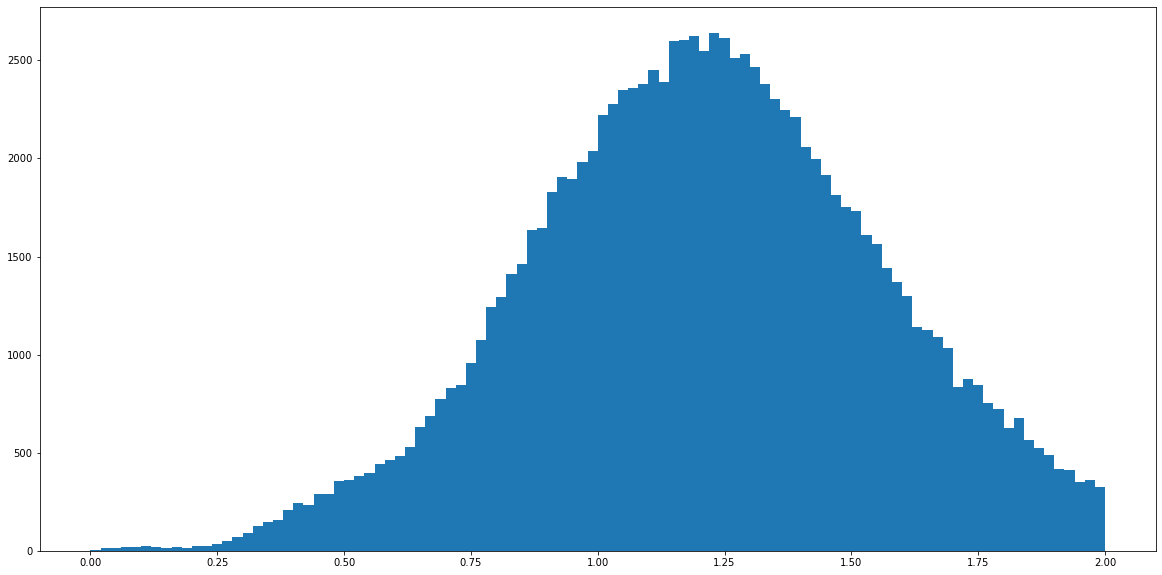

In [300]:
plt.hist(normalized_yfp_last.values,range=(0,2),bins=100)
plt.show()

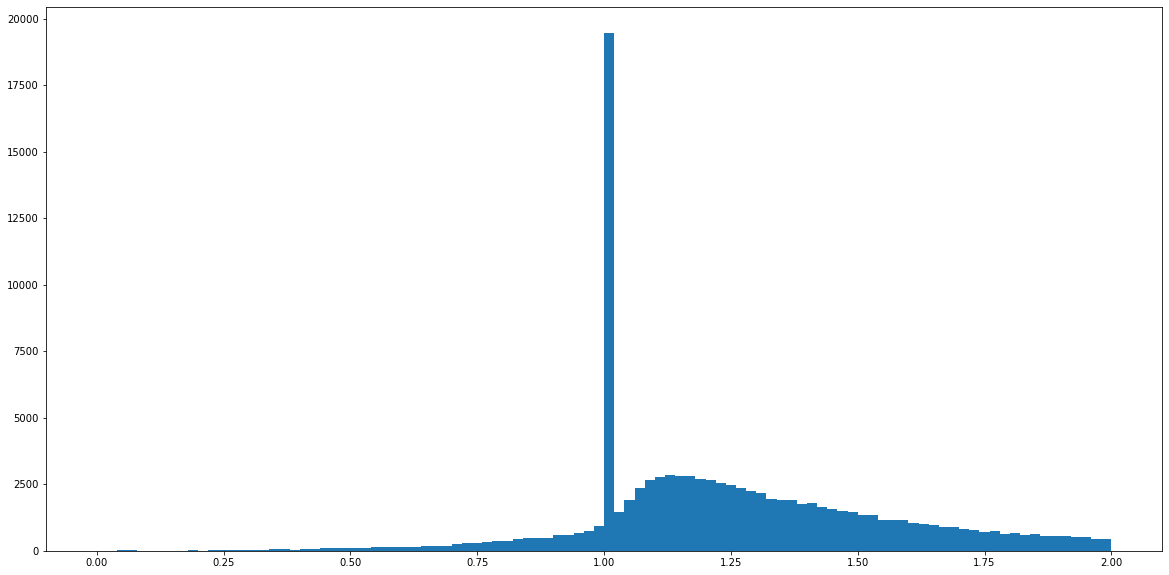

In [303]:
plt.hist(normalized_signal_ratio.values,range=(0,2),bins=100)
plt.show()

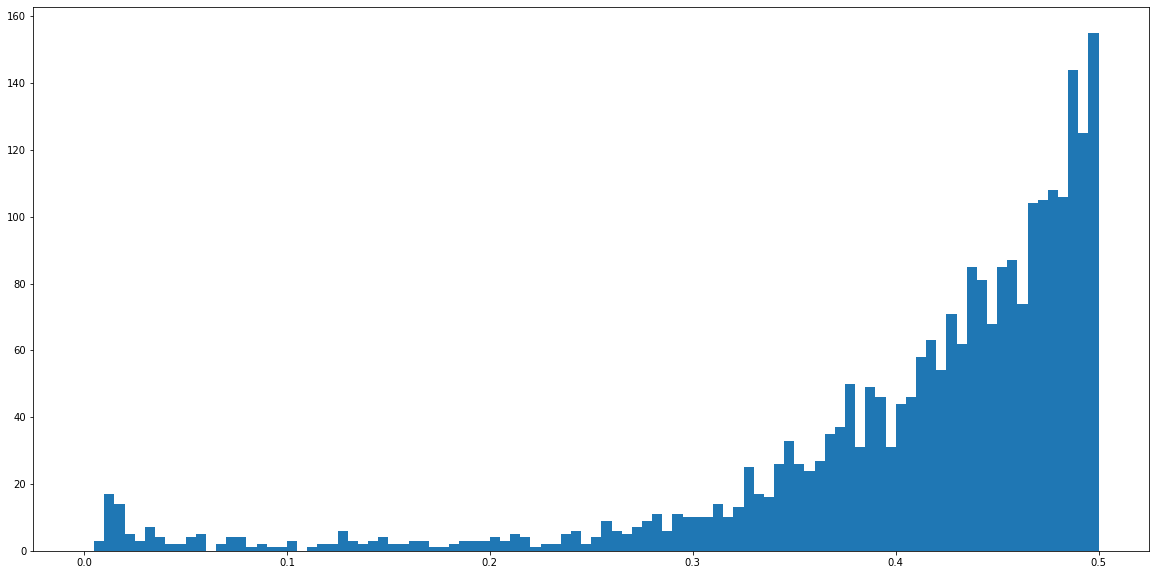

In [251]:
plt.hist(signal_ratio,range=(0,0.5),bins=100)
plt.show()

In [249]:
max(signal_ratio)

34.53625718981101

In [185]:
cell_last_tpt_df["YFP mean_intensity"]<250

Dask Series Structure:
npartitions=16
110000         bool
6100150000      ...
               ... 
83100130000     ...
92500090008     ...
Name: YFP mean_intensity, dtype: bool
Dask Name: lt, 48 tasks

In [235]:
signal_ratio = yfp_signal_last/yfp_signal_first

In [331]:
# plas_loss_last_tpt_df = cell_last_tpt_df[signal_ratio<0.3]
plas_loss_last_tpt_df = cell_last_tpt_df[normalized_signal_ratio<0.5]
plas_loss_last_tpt_df = plas_loss_last_tpt_df[plas_loss_last_tpt_df["CellID"] == 0]

/home/de64/miniconda3/envs/trenchripper/lib/python3.7/site-packages/dask/dataframe/core.py:3388: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  meta = self._meta[_extract_meta(key)]


In [332]:
plas_loss_last_tpt_df.compute()

,index,File Index,File Trench Index,timepoints,CellID,Trench Score,Mother CellID,Daughter CellID 1,Daughter CellID 2,Sister CellID,...,trenchid,fov,row,trench,time (s),lane orientation,y (local),x (local),y (global),x (global)
Global CellID,,,,,,,,,,,,,,,,,,,,,
4100070000,41000702040000,41,7,204,0,-84.370433,-1,-1,-1,-1,...,1032,3,0,81,122429.328973,top,164.061761,491.535533,-4080.938239,-2783.164467
11700030000,117000300220000,117,3,22,0,-74.213835,-1,11700030027,11700030028,-1,...,2928,8,3,57,13250.560357,top,569.180604,330.722520,-3015.719396,7711.922520
14300110000,143001100320000,143,11,32,0,-74.414460,-1,14300110101,14300110102,-1,...,3586,10,1,51,19262.438941,top,210.193979,300.509166,-3374.806021,2353.509166
23100220000,231002200460000,231,22,46,0,-71.193808,-1,23100220121,23100220122,-1,...,5797,16,1,56,27741.861133,top,333.321518,339.819014,-1271.678482,-4933.180986
23300110000,233001100370000,233,11,37,0,-73.757875,-1,23300110043,23300110044,-1,...,5836,16,1,95,22342.076533,top,333.321518,589.647715,-1271.578482,-4683.352285
25600210000,256002100260000,256,21,26,0,-74.172684,-1,25600210059,25600210060,-1,...,6421,18,1,28,15758.750509,top,346.966259,164.711511,-1258.033741,4881.911511
26100170000,261001700470000,261,17,47,0,-83.877276,-1,26100170042,26100170043,-1,...,6542,18,2,37,28359.502117,top,522.398637,225.463093,-1082.601363,4942.663093
28200210000,282002100010000,282,21,1,0,-71.689218,-1,28200210014,28200210015,-1,...,7071,20,0,23,770.883397,top,38.660098,132.224033,-906.339902,4849.224033
30100190000,301001900150000,301,19,15,0,-75.342048,-1,30100190036,30100190037,-1,...,7544,21,0,54,9178.955197,top,34.761601,330.722520,-910.238399,1051.622520


In [317]:
first_div_time_loss = plas_loss_last_tpt_df['timepoints'].compute()

In [333]:
%matplotlib inline

In [318]:
len(plas_loss_last_tpt_df)

25

In [334]:
matplotlib.rcParams["figure.figsize"] = [20, 10]

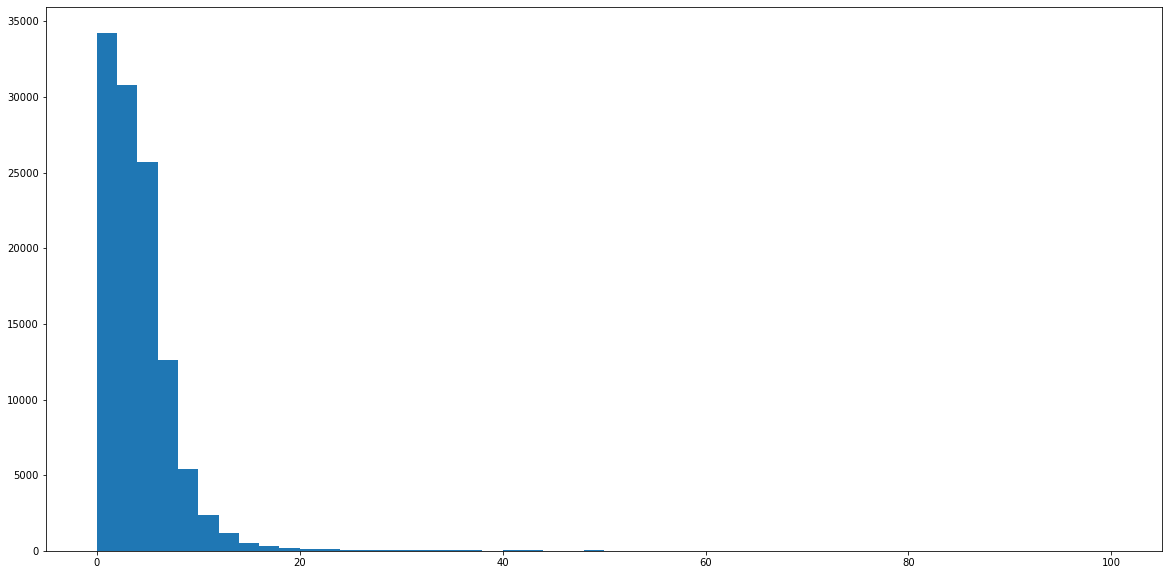

In [339]:
plt.hist(first_div_time.values,bins=50,range=(0,100))
plt.show()

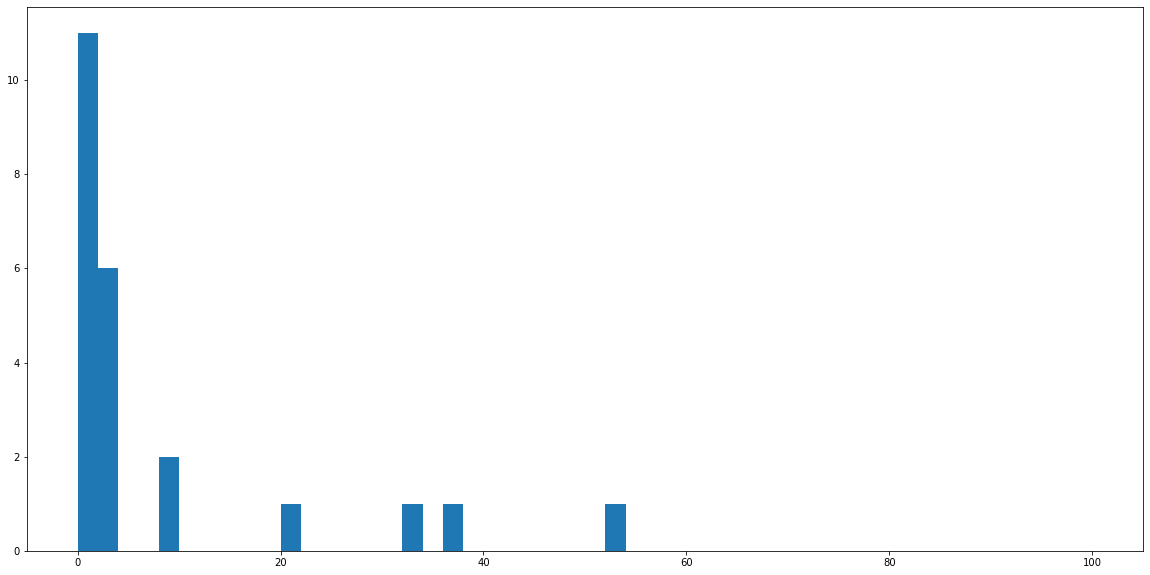

In [340]:
plt.hist(first_div_time_loss.values,bins=50,range=(0,100))
plt.show()

In [176]:
first_div_time.values

array([274,   9,   4, ...,   2,   2,   1])

In [52]:
mothers_daughters_df.groupby(['Global CellID'])[""]

114233

In [ ]:
original_cell_df = cell_max_tpt_df.loc[original_cell_ids]

In [ ]:
cell_max_tpt_df = reference_df.loc[cells_max_tpt.tolist()].set_index('Global CellID').persist()

In [ ]:
cells_max_tpt = reference_df.groupby(['Global CellID'])['timepoints'].idxmax().compute()

In [79]:
mother_df[:50]

,index,File Index,File Trench Index,timepoints,CellID,Global CellID,Trench Score,Mother CellID,Daughter CellID 1,Daughter CellID 2,...,fov,row,trench,time (s),lane orientation,y (local),x (local),y (global),x (global),Normalized YFP
index,,,,,,,,,,,,,,,,,,,,,
7002100000000,7002100000000,7,21,0,0,700210000,-59.959295,-1,700210012,700210013,...,0,1,5,24.190117,top,329.098146,17.543238,-3915.801854,-7253.356762,0.578769
7002100010000,7002100010000,7,21,1,0,700210000,-59.959295,-1,700210012,700210013,...,0,1,5,623.375077,top,329.098146,17.543238,-3915.801854,-7253.256762,0.612317
10000400000000,10000400000000,10,4,0,0,1000040000,-69.551776,-1,1000040013,1000040014,...,0,1,63,24.190117,top,329.098146,216.691474,-3915.801854,-7054.208526,0.315645
10000400010000,10000400010000,10,4,1,0,1000040000,-69.551776,-1,1000040013,1000040014,...,0,1,63,623.375077,top,329.098146,216.691474,-3915.801854,-7054.108526,0.337839
10000400020000,10000400020000,10,4,2,0,1000040000,-69.551776,-1,1000040013,1000040014,...,0,1,63,1223.494525,top,329.098146,216.691474,-3915.801854,-7054.108526,0.429067
11000500000000,11000500000000,11,5,0,0,1100050000,-73.754114,-1,1100050014,1100050015,...,0,1,89,24.190117,top,329.098146,308.631036,-3915.801854,-6962.268964,0.423748
11000500010000,11000500010000,11,5,1,0,1100050000,-73.754114,-1,1100050014,1100050015,...,0,1,89,623.375077,top,329.098146,308.631036,-3915.801854,-6962.168964,0.406538
11000500020000,11000500020000,11,5,2,0,1100050000,-73.754114,-1,1100050014,1100050015,...,0,1,89,1223.494525,top,329.098146,308.631036,-3915.801854,-6962.168964,0.498267
16000300000000,16000300000000,16,3,0,0,1600030000,-63.753809,-1,1600030004,1600030005,...,0,2,19,24.190117,top,504.855399,65.624704,-3740.044601,-7205.275296,0.354079


## Region Properties (No Lineage)

In [ ]:
analyzer = tr.analysis.regionprops_extractor(
    headpath, "fluorsegmentation", intensity_channel_list=["mCherry", "YFP"]
)

In [ ]:
analyzer.export_all_data()

In [139]:
idx = 0
print(file_indices[idx])
print(trench_indices[idx])

3
23


In [140]:
trench_indices

array([23,  2, 21,  3,  2, 21,  9, 10, 13, 23, 13, 15,  9, 20, 21,  5, 10,
        6, 12, 22, 10,  1,  6, 14, 17, 10,  4, 14,  3,  0,  5,  6, 24, 22,
       24,  4, 10, 13, 19, 17, 18,  4, 11, 15, 18, 13,  7, 17, 12,  8, 20,
       10, 13, 20,  2, 20, 17, 23,  9, 14, 19, 21,  0, 21, 19,  9, 17,  8,
        2, 11,  0,  1,  2,  3,  4,  5, 14,  1,  2,  8,  7, 11,  3, 21, 22,
       20,  4, 21, 19, 21, 12, 18, 15, 13,  6,  2, 22,  2, 10,  4, 21, 20,
       22, 24, 19,  1, 21,  8, 22,  5,  9, 20])

## Inspect Kymographs

In [151]:
%matplotlib widget

In [152]:
from ipywidgets import interactive, IntText, IntSlider

kyview = tr.analysis.kymograph_viewer(headpath, "YFP", "fluorsegmentation")

In [153]:
kyviewer = interactive(
    kyview.inspect_trench,
    {"manual": True},
    file_idx=IntText(value=0, description="File Index:", disabled=False),
    trench_idx=IntText(value=0, description="Trench Index:", disabled=False),
    x_size=IntSlider(
        value=32, description="X Size:", min=0, max=50, step=1, disabled=False
    ),
    y_size=IntSlider(
        value=15, description="Y Size:", min=0, max=30, step=1, disabled=False
    ),
)
display(kyviewer)

interactive(children=(IntText(value=0, description='File Index:'), IntText(value=0, description='Trench Index:…

In [310]:
interact(
    interactive_kymograph.view_image,
    fov_idx=IntText(value=0, description="FOV number:", disabled=False),
    t=IntSlider(
        value=0, min=0, max=timepoints_len - 1, step=1, continuous_update=False
    ),
    channel=Dropdown(
        options=channels, value=channels[0], description="Channel:", disabled=False
    ),
    invert=Dropdown(options=[True, False], value=False),
)

NameError: name 'interact' is not defined

## Phase Segmentation Training

### Data Preparation

In [ ]:
dataloader = tr.unet.UNet_Training_DataLoader(
    nndatapath="/n/scratch2/de64/nntest7",
    experimentname="First NN",
    trainpath="/n/scratch2/de64/2019-06-18_DE85_training_data",
    testpath="/n/scratch2/de64/2019-05-31_validation_data",
    valpath="/n/scratch2/de64/2019-05-31_validation_data",
)

In [ ]:
dataloader = tr.unet.UNet_Training_DataLoader(
    nndatapath="/n/scratch2/de64/nntest8",
    experimentname="First NN",
    trainpath="/n/scratch2/de64/2019-05-31_validation_data",
    testpath="/n/scratch2/de64/2019-06-18_DE85_training_data",
    valpath="/n/scratch2/de64/2019-06-18_DE85_training_data",
)

In [ ]:
dataloader = tr.unet.UNet_Training_DataLoader(
    nndatapath="/n/scratch2/de64/nntest9",
    experimentname="First NN",
    trainpath="/n/scratch2/de64/2019-05-31_validation_data",
    testpath="/n/scratch2/de64/2019-06-18_DE85_training_data",
    valpath="/n/scratch2/de64/2019-06-18_DE85_training_data",
)

In [ ]:
dataloader = tr.unet.UNet_Training_DataLoader(
    nndatapath="/n/scratch2/de64/nntest10",
    experimentname="First NN",
    trainpath="/n/scratch2/de64/2019-06-18_DE85_training_data",
    testpath="/n/scratch2/de64/2019-05-31_validation_data",
    valpath="/n/scratch2/de64/2019-05-31_validation_data",
)

#### Training Set Selection

In [ ]:
dataloader.inter_get_selection(dataloader.trainpath, "train")

#### Test Set Selection

In [ ]:
dataloader.inter_get_selection(dataloader.testpath, "test")

#### Validation Set Selection

In [ ]:
dataloader.inter_get_selection(dataloader.valpath, "val")

#### Weightmap Parameters

In [ ]:
dataloader.display_grid()

In [ ]:
dataloader.get_grid_params()

#### Export

In [ ]:
dataloader.export_all_data(memory="6GB")

### Hyperparameter (Grid) Search

#### Set-up Search

In [ ]:
grid = tr.unet.GridSearch("/n/scratch2/de64/nntest10", numepochs=15)

In [ ]:
grid.display_grid()

In [ ]:
grid.get_grid_params()

#### Run Search

In [ ]:
grid.run_grid_search(gres="gpu:teslaK80:1")

#### Evaluate Results

In [ ]:
%matplotlib ipympl
matplotlib.rcParams["figure.figsize"] = [12, 8]

import seaborn as sns

sns.set()
sns.set(font_scale=2)

In [ ]:
vis = tr.unet.TrainingVisualizer(
    "/n/scratch2/de64/nntest10", "/n/groups/paulsson/Daniel/NNModels"
)

In [ ]:
vis.inter_plot_loss("Val Loss")
vis.grid_widget.on("filter_changed", vis.handle_filter_changed)

In [ ]:
vis.grid_widget

In [ ]:
vis.inter_df_columns()

In [ ]:
vis.model_widget

In [ ]:
import matplotlib
from matplotlib import pyplot as plt

%matplotlib inline

plt.hist(vis.model_df["Val F1 Cell Scores"][0], bins=50)
plt.xlabel("F-Score")
plt.ylabel("Occurances")
plt.xticks(np.arange(0, 1.01, step=0.5))
plt.draw()

In [ ]:
headpath = "/n/scratch2/de64/2019-07-08_bacillus_rodz_mut_expt_bmbm_ti4"
unetseg = tr.unet.UNet_Segmenter(
    headpath, "Phase", "/n/groups/paulsson/Daniel/NNModels", min_obj_size=20
)

In [ ]:
choose_channel = interactive(
    unetseg.choose_seg_channel,
    {"manual": True},
    seg_channel=Dropdown(options=unetseg.all_channels, value=unetseg.all_channels[0]),
)
display(choose_channel)

In [ ]:
unetseg.inter_df_columns()

In [ ]:
import torch
import numpy as np
import h5py
import trenchripper as tr
from matplotlib import pyplot as plt

In [ ]:
with h5py.File("/n/scratch2/de64/nntest7/test.hdf5", "r") as infile:
    img_arr = torch.Tensor(infile["img"][535:550])
    seg_arr = torch.Tensor(infile["seg"][100:200:10])
    weight_arr = infile["weight_(10.0, 4.0)"][0:300:10]

In [ ]:
testunet = tr.unet.UNet(1, 2, layers=3, hidden_size=32, dropout=0.0, withsoftmax=True)
device = torch.device("cpu")
testunet.load_state_dict(
    torch.load("/n/scratch2/de64/nntest7/models/0.pt", map_location=device)
)

In [ ]:
y = testunet.forward(img_arr).detach().numpy()[:, 1]
x = img_arr.detach().numpy().squeeze(1)

In [ ]:
x.shape

In [ ]:
plt.imshow(x[4])

In [ ]:
plt.imshow(y[4])

In [ ]:
img_kymo = tr.utils.kymo_handle()
img_kymo.import_wrap(x)
img = img_kymo.return_unwrap(padding=0)
plt.imshow(img)

In [ ]:
seg_kymo = tr.utils.kymo_handle()
seg_kymo.import_wrap(y)
seg = seg_kymo.return_unwrap(padding=0)
plt.imshow(seg)

In [ ]:
mask = seg > 0.6
plt.imshow(mask)

In [ ]:
import skimage as sk

In [ ]:
filtered_mask = sk.morphology.remove_small_objects(mask, min_size=30)

In [ ]:
plt.imshow(filtered_mask)

## Other

#### Transfer files into the scratch folder

If you are working on the HMS O2 server, this is a convenience function to facilitate transfer of files onto the `/n/scratch2` folder.

In [ ]:
sourcedir = "/n/files/SysBio/PAULSSON\ LAB/SILVIA/Ti4--Data/2020_03_28--PlasmidLosses_SJC25_SJC28/temp"
targetdir = "/n/scratch2/de64/2020-03-02_plasmid_loss"
tr.trcluster.transferjob(sourcedir, targetdir)

#### Dask Utilities

In [ ]:
dask_controller.shutdown()

In [ ]:
dask_controller.retry_failed()

In [ ]:
dask_controller.daskclient.restart()

In [ ]:
dask_controller.retry_processing()